## 1. Packges included

In [1]:
import pandas as pd
from pandas import *
import numpy as np
import os
from datetime import *
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import csv
from zipfile import ZipFile
import math
import collections
import filecmp
import xml.etree.ElementTree as ET
import geopandas as gpd
from shapely import wkt
import openpyxl
import re

In [2]:
# load road network
road_network = "C:\\Users\\guoqq17\\Desktop\\C2Smart\\SUMO calibration\\sumo_network_test\\test_2_traffic_sig_revise_4.net.xml"
with open(road_network, 'r') as f:
    road_network_xml = f.read()
test_road_network_xml = '''    <edge id=":1178349141_8" function="internal">
        <lane id=":1178349141_8_0" index="0" disallow="pedestrian tram rail_urban rail rail_electric rail_fast ship" speed="13.41" length="25.47" shape="3022.60,4223.15 3044.14,4236.75"/>
    </edge>
    <edge id=":1178349141_9" function="internal">
        <lane id=":1178349141_9_0" index="0" disallow="pedestrian tram rail_urban rail rail_electric rail_fast ship" speed="9.30" length="9.51" shape="3022.60,4223.15 3027.18,4226.91 3028.84,4230.09"/>
    </edge>'''
x = re.findall('<lane id="([#A-Za-z0-9_.]*)_0".*length="([0-9.]*)".*', road_network_xml)

edge_length = []
edge_ids = []
for i in x:
    edge_ids.append(i[0])
    edge_length.append(float(i[1]))

data = {'sumo_id': edge_ids, 'length_meters': edge_length}
length_in_meter = pd.DataFrame.from_dict(data)

In [3]:

base_path = "C:\\Users\\guoqq17\\Desktop\\C2Smart\\SUMO calibration\\sumo_network_test"
sumo2tmc = pd.read_csv("{}\\data_for_calibration\\sumo_data_correlation.csv".format(base_path))
sumo2sensys = pd.read_csv("{}\\data_for_calibration\\sumo_vol_cor.csv".format(base_path))
sumo2vissim = pd.read_csv("{}\\data_for_calibration\\vissim_sumo_table.csv".format(base_path))

In [4]:
text = '<edge id="-105493444#1" sampledSeconds="745.53" traveltime="8.77" overlapTraveltime="10.25" density="5.29" laneDensity="1.76" occupancy="0.78" waitingTime="344.00" speed="4.31" departed="2" arrived="0" entered="71" left="73" laneChangedFrom="2" laneChangedTo="2"/>'
def parseEdgeResult(text, key):
    find = text.find(key+"=")
    if find == -1:
        return -1
    start = find + len(key)+2
    end = text.find(' ', start) -1
    return text[start:end]
parseEdgeResult(text, "idx")

-1

In [184]:
#sumo_edge_xml_file = '{}\\Edgetest_6_0411_2_0.xml'.format(base_path)
sumo_edge_xml_file = r"C:\\Users\guoqq17\Desktop\C2Smart\sumo_project\output_r1\edge_data_output.xml"

In [166]:
# get sensys volume
path = "{}\\data_for_calibration\\ground_truth_mingjian\\wsdot_loop.csv".format(base_path)
loop_vol_sumo = pd.read_csv(path)
column = loop_vol_sumo.shape[1]

In [167]:

start = 0
with open(sumo_edge_xml_file, 'r') as f:
    line = f.readline()
    while line:
        if "<interval" in line:
            start+=1
            loop_vol_sumo.insert(loop_vol_sumo.shape[1], start, -1)
            column = loop_vol_sumo.shape[1]
        elif "<edge" in line:
            edge_id = parseEdgeResult(line, "id")
            loc = loop_vol_sumo.loc[loop_vol_sumo['sumoid'] == edge_id]
            if not loc.empty:
                volume = float(parseEdgeResult(line, "entered"))+float(parseEdgeResult(line, "departed"))
                loop_vol_sumo.at[loc.index, start] = volume
        line = f.readline()
loop_vol_sumo

,Order,sumoid,name,Metered,AM peak,AAWDT,loop,v5,v6,v7,v8,v9,1,2,3,4
0,5001.0,402084473,I-5 SB Mainline,0,6740,97140,005es16661,NaN,5665.000000,6242.000000,5258.000000,5205.000000,4565,5194,3046,2034
1,NaN,22768206,I-5 Mercer On Ramp,0,1220,25320,005es16661_MS_P,NaN,745.000000,1184.000000,1113.000000,972.000000,900,550,1000,1000
2,5002.0,4722443,I-5 SB Exit Stewart,0,770,8070,diff,NaN,41.000000,568.000000,562.000000,405.000000,432,698,41,9
3,NaN,452336728,After Stewart,0,6650,100120,005es16640:_MS_,NaN,6369.000000,6858.000000,5809.000000,5772.000000,4048,4186,2573,1861
4,5003.0,4755219#0,I-5 SB Enter Yale Ave,0,1110,19770,005es16640:_MS_O,NaN,671.000000,1111.000000,1080.000000,968.000000,475,697,567,422
5,5004.0,96260970,I-5 SB Exit Union St,0,1020,10380,005es16583*,NaN,748.000000,991.000000,971.000000,964.000000,671,1516,1277,991
6,5005.0,96260967,I-5 SB Exit 6th Ave,0,1470,15270,005es16583*,NaN,1173.000000,1384.000000,1478.000000,1335.000000,1096,1686,997,732
7,5006.0,96260966,I-5 SB CD,0,2880,37740,005es16551,NaN,2210.000000,2346.000000,1820.000000,1990.000000,2163,1561,1012,856
8,5007.0,35824613,I-5 SB CD Enter Spring,0,1070,19820,NaN,NaN,NaN,NaN,NaN,NaN,148,596,1292,1526
9,5008.0,49394449,I-5 SB CD Enter James St,0,1210,19200,NaN,NaN,NaN,NaN,NaN,NaN,39,124,296,304


In [168]:
loop_vol_sumo['geh'] = loop_vol_sumo.apply(lambda x: get_GEH(x['AM peak'], max( x[1],x[2], x[3], x[4])), axis=1)
loop_vol_sumo['diff'] = loop_vol_sumo.apply(lambda x: x['AM peak'] - max( x[1],x[2], x[3], x[4]), axis=1)
loop_vol_sumo['sumo_am_peak'] = loop_vol_sumo[[1,2,3,4]].max(axis=1)
loop_vol_sumo['loop_am_peak']=loop_vol_sumo['AM peak']
#loop_vol_sumo['geh'] = loop_vol_sumo.apply(lambda x: get_GEH(x['AM peak'], max(x[0], x[1])), axis=1)
#loop_vol_sumo['diff'] = loop_vol_sumo.apply(lambda x: x['AM peak'] - max(x[0], x[1]), axis=1)

In [169]:
loop_vol_sumo['met'] = False
loop_vol_sumo.loc[loop_vol_sumo['geh']<5, 'met'] = True
loop_vol_sumo.loc[(abs(loop_vol_sumo['diff'])<100) & (loop_vol_sumo['AM peak']<700), 'met'] = True
loop_vol_sumo.loc[(abs(loop_vol_sumo['diff']/loop_vol_sumo['AM peak'])<0.15) & (loop_vol_sumo['AM peak']>=700) & (loop_vol_sumo['AM peak']<2700), 'met'] = True
loop_vol_sumo.loc[(abs(loop_vol_sumo['diff'])<400) & (loop_vol_sumo['AM peak']>2700), 'met'] = True




In [170]:
loop_vol_sumo[['sumoid', 'name', 'loop_am_peak', 'sumo_am_peak', 'geh', 'met']]

,sumoid,name,loop_am_peak,sumo_am_peak,geh,met
0,402084473,I-5 SB Mainline,6740,5194,400.555723,False
1,22768206,I-5 Mercer On Ramp,1220,1000,43.603604,False
2,4722443,I-5 SB Exit Stewart,770,698,7.062670,True
3,452336728,After Stewart,6650,4186,1120.578811,False
4,4755219#0,I-5 SB Enter Yale Ave,1110,697,188.786940,False
5,96260970,I-5 SB Exit Union St,1020,1516,194.018927,False
6,96260967,I-5 SB Exit 6th Ave,1470,1686,29.566540,True
7,96260966,I-5 SB CD,2880,2163,203.882213,False
8,35824613,I-5 SB CD Enter Spring,1070,1526,160.197227,False
9,49394449,I-5 SB CD Enter James St,1210,304,1084.327609,False


loop_vol_sumo[['Order', 'sumoid', 'name', 'AM peak', 'loop', 1, 2, 3, 4, 'diff', 'met']]

In [128]:
loop_vol_sumo[['Order', 'sumoid', 'name', 'AM peak', 'loop', 1, 2, 3, 4, 'diff', 'met', 'geh']]

,Order,sumoid,name,AM peak,loop,1,2,3,4,diff,met,geh
0,5001.0,402084473,I-5 SB Mainline,6740,005es16661,4566,4684,3790,1321,2056,False,740.044818
1,NaN,22768206,I-5 Mercer On Ramp,1220,005es16661_MS_P,900,550,1000,1000,220,False,43.603604
2,5002.0,4722443,I-5 SB Exit Stewart,770,diff,451,486,141,138,284,False,128.433121
3,NaN,452336728,After Stewart,6650,005es16640:_MS_,4019,3914,2645,1527,2631,False,1297.621333
4,5003.0,4755219#0,I-5 SB Enter Yale Ave,1110,005es16640:_MS_O,477,1020,530,473,90,True,7.605634
5,5004.0,96260970,I-5 SB Exit Union St,1020,005es16583*,652,1413,1095,938,-393,False,126.961776
6,5005.0,96260967,I-5 SB Exit 6th Ave,1470,005es16583*,1072,1780,876,707,-310,False,59.138462
7,5006.0,96260966,I-5 SB CD,2880,005es16551,2173,1583,1166,1014,707,False,197.842470
8,5007.0,35824613,I-5 SB CD Enter Spring,1070,NaN,129,458,1118,1741,-671,False,320.342227
9,5008.0,49394449,I-5 SB CD Enter James St,1210,NaN,39,136,266,188,944,False,1207.501355


In [27]:
loop_vol_sumo.groupby(by=['loop','met']).size()

loop                 met  
005es16377:_MN_Stn   False    1
005es16551           False    1
005es16583*          False    2
005es16640:_MS_      False    1
005es16640:_MS_O     True     1
005es16661           False    1
005es16661_MS_P      False    1
090es00278:_MW_X_12  False    1
090es00278:_MW__12   False    1
090es00302:_MW       False    1
diff                 False    1
dtype: int64

In [14]:
# get sensys volume
vissim_vol_sumo = pd.DataFrame.copy(sumo2vissim)
column = vissim_vol_sumo.shape[1]
#sumo_edge_xml_file = '{}\\Edgetest_4.xml'.format(base_path)
start = -1
with open(sumo_edge_xml_file, 'r') as f:
    line = f.readline()
    while line:
        if "<interval" in line:
            start+=1
            vissim_vol_sumo.insert(vissim_vol_sumo.shape[1], start, -1)
            column = vissim_vol_sumo.shape[1]
        elif "<edge" in line:
            edge_id = parseEdgeResult(line, "id")
            loc = vissim_vol_sumo.loc[vissim_vol_sumo['sumoid'] == edge_id]
            if not loc.empty:
                volume = float(parseEdgeResult(line, "entered"))+ float(parseEdgeResult(line, "departed"))
                vissim_vol_sumo.at[loc.index, start] = volume
        line = f.readline()
vissim_vol_sumo

,No,Link,Volume,sumoid,0,1,2,3,4
0,569,2925: 1 Ave S,2011,427915134,189,267,746,540,188
1,2809,732: 4th Ave S,1840,gneE448,16,28,943,741,414
2,2788,184: Western Ave W,1759,-22759220#9,68,63,255,178,271
3,2835,1019: I-5 CD NB Off-Ramp,1640,56178980,301,1068,638,375,261
4,555,2854: 4th Ave S,1314,159591156,0,15,521,546,331
...,...,...,...,...,...,...,...,...,...
93,2905,1395: Yale Ave N,10,-174870950#0,55,291,111,105,101
94,549,2833: S Forest St,9,159591156,0,15,521,546,331
95,550,2839: S Horton St,7,159591156,0,15,521,546,331
96,2776,87: Union St,6,-8111112#1,0,0,0,0,0


In [15]:
vissim_vol_sumo['diff'] = (visssim_vol_sumo['Volume'] - vissim_vol_sumo[3])/vissim_vol_sumo['Volume']
vissim_vol_sumo[vissim_vol_sumo[0]>0].sort_values('diff').head(60)

NameError: name 'visssim_vol_sumo' is not defined

In [205]:
# get sensys volume
vissim_vol_sumo = pd.DataFrame.copy(sumo2vissim)
column = vissim_vol_sumo.shape[1]

start = -1
with open(sumo_edge_xml_file, 'r') as f:
    line = f.readline()
    while line:
        if "<interval" in line:
            start+=1
            vissim_vol_sumo.insert(vissim_vol_sumo.shape[1], start, -1)
            column = vissim_vol_sumo.shape[1]
        elif "<edge" in line:
            edge_id = parseEdgeResult(line, "id")
            loc = vissim_vol_sumo.loc[vissim_vol_sumo['sumoid'] == edge_id]
            if not loc.empty:
                volume = float(parseEdgeResult(line, "entered"))+ float(parseEdgeResult(line, "departed"))
                vissim_vol_sumo.at[loc.index, start] = volume
        line = f.readline()
vissim_vol_sumo['diff'] = (vissim_vol_sumo['Volume'] - vissim_vol_sumo[3])/vissim_vol_sumo['Volume']
vissim_vol_sumo[vissim_vol_sumo[0]>0].sort_values('diff').head(60)

,No,Link,Volume,sumoid,0,1,2,3,diff
97,557,2860,3,159591156,4,36,291,501,-166.000000
95,550,2839: S Horton St,7,159591156,4,36,291,501,-70.571429
94,549,2833: S Forest St,9,159591156,4,36,291,501,-54.666667
91,552,2847,13,159591156,4,36,291,501,-37.538462
87,2902,1369: Minor Ave N,20,-560096280#2,343,665,371,367,-17.350000
89,2908,1419: E Howell St,20,-6430733#1,40,158,222,292,-13.600000
72,548,2832,38,159591156,4,36,291,501,-12.184211
93,2905,1395: Yale Ave N,10,-174870950#0,30,84,76,110,-10.000000
63,556,2858: Costco Drive Way,52,159591156,4,36,291,501,-8.634615
66,2803,447: Warren Ave N,50,-6397904,435,409,373,339,-5.780000


In [185]:
sumo_edge_xml_file

'C:\\\\Users\\guoqq17\\Desktop\\C2Smart\\sumo_project\\output_r1\\edge_data_output.xml'

In [206]:
# get sensys volume
sensys_vol_sumo = pd.DataFrame.copy(sumo2sensys)
column = sensys_vol_sumo.shape[1]

start = -1
offset = 5
with open(sumo_edge_xml_file, 'r') as f:
    line = f.readline()
    while line:
        if "<interval" in line:
            start+=1
            #sensys_vol_sumo.insert(sensys_vol_sumo.shape[1], start, -1)
            #column = sensys_vol_sumo.shape[1]
        elif "<edge" in line:
            edge_id = parseEdgeResult(line, "id")
            loc = sensys_vol_sumo.loc[sensys_vol_sumo['sumoid'] == edge_id]
            if not loc.empty:
                volume = float(parseEdgeResult(line, "entered"))+ float(parseEdgeResult(line, "departed"))
                sensys_vol_sumo.at[loc.index, start+5] = volume
        line = f.readline()
sensys_vol_sumo

,sumoid,sensorid,dir,5,6,7,8
0,462696719#1,apeg0244,sb,5.0,6.0,20.0,84.0
1,428230587,apeg0261,nb,41.0,127.0,959.0,409.0
2,22927950#2,apeg0258,sb,7.0,16.0,92.0,84.0
3,-61032261#0,apeg0258,nb,0.0,0.0,1.0,32.0
4,6508961#0,apeg0243,sb,21.0,115.0,721.0,894.0
5,-354215257#1,apeg0252,sb,13.0,23.0,344.0,526.0
6,462696736#1,apeg0252,nb,66.0,222.0,382.0,356.0
7,332946371#3,apeg0249,nb,202.0,601.0,492.0,303.0
8,-428088903,apeg0265,wb,0.0,1.0,10.0,130.0
9,-428231560,apeg0265,eb,0.0,3.0,3.0,18.0


In [187]:
sensys_truth = pd.read_csv('C:\\Users\\guoqq17\\Desktop\C2Smart\SUMO calibration\\sumo_network_test\\data_for_calibration\\ground_truth_mingjian\\sensys_vol.csv')
sensys_truth

,Unnamed: 0,sumoid,sensorid,dir,sensor_ids,sensor_id,6,7,8,9,10
0,0,462696719#1,apeg0244,sb,0244SSBT,0244SSBT,278.0,518.0,602.0,550.0,546.0
1,1,428230587,apeg0261,nb,0261SNBT,0261SNBT,929.0,1816.0,1954.0,1772.0,1408.0
2,2,22927950#2,apeg0258,sb,0258SSBT,0258SSBT,190.0,307.0,387.0,328.0,320.0
3,3,-61032261#0,apeg0258,nb,0258SNBT,0258SNBT,6.0,13.0,12.0,12.0,12.0
4,4,6508961#0,apeg0243,sb,0243SSBT,0243SSBT,380.0,584.0,615.0,618.0,572.0
5,5,-354215257#1,apeg0252,sb,0252SSBT,0252SSBT,103.0,235.0,363.0,278.0,281.0
6,6,462696736#1,apeg0252,nb,0252SNBT,0252SNBT,430.0,624.0,852.0,797.0,676.0
7,7,332946371#3,apeg0249,nb,0249SNBT,0249SNBT,314.0,365.0,423.0,404.0,365.0
8,8,-428088903,apeg0265,wb,0265SWBT,0265SWBT,412.0,753.0,738.0,718.0,747.0
9,9,-428231560,apeg0265,eb,0265SEBT,0265SEBT,0.0,0.0,1.0,6.0,14.0


In [201]:

sensys_vol_sumo['vol_median'] =sensys_vol_sumo[[5,6,7,8]].median(axis=1)
sensys_truth['truth_median'] = sensys_truth[['6','7','8','9','10']].median(axis=1)
sensys_vol_sumo.merge(sensys_truth, on = 'sumoid')

C:\Users\guoqq17\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,sumoid,sensorid_x,dir_x,5,6,7,8,vol_median,Unnamed: 0,sensorid_y,dir_y,sensor_ids,sensor_id,6,7,8,9,10,truth_median
0,462696719#1,apeg0244,sb,5.0,6.0,20.0,84.0,13.0,0,apeg0244,sb,0244SSBT,0244SSBT,278.0,518.0,602.0,550.0,546.0,546.0
1,428230587,apeg0261,nb,41.0,127.0,959.0,409.0,268.0,1,apeg0261,nb,0261SNBT,0261SNBT,929.0,1816.0,1954.0,1772.0,1408.0,1772.0
2,22927950#2,apeg0258,sb,7.0,16.0,92.0,84.0,50.0,2,apeg0258,sb,0258SSBT,0258SSBT,190.0,307.0,387.0,328.0,320.0,320.0
3,-61032261#0,apeg0258,nb,0.0,0.0,1.0,32.0,0.5,3,apeg0258,nb,0258SNBT,0258SNBT,6.0,13.0,12.0,12.0,12.0,12.0
4,6508961#0,apeg0243,sb,21.0,115.0,721.0,894.0,418.0,4,apeg0243,sb,0243SSBT,0243SSBT,380.0,584.0,615.0,618.0,572.0,584.0
5,-354215257#1,apeg0252,sb,13.0,23.0,344.0,526.0,183.5,5,apeg0252,sb,0252SSBT,0252SSBT,103.0,235.0,363.0,278.0,281.0,278.0
6,462696736#1,apeg0252,nb,66.0,222.0,382.0,356.0,289.0,6,apeg0252,nb,0252SNBT,0252SNBT,430.0,624.0,852.0,797.0,676.0,676.0
7,332946371#3,apeg0249,nb,202.0,601.0,492.0,303.0,397.5,7,apeg0249,nb,0249SNBT,0249SNBT,314.0,365.0,423.0,404.0,365.0,365.0
8,-428088903,apeg0265,wb,0.0,1.0,10.0,130.0,5.5,8,apeg0265,wb,0265SWBT,0265SWBT,412.0,753.0,738.0,718.0,747.0,738.0
9,-428231560,apeg0265,eb,0.0,3.0,3.0,18.0,3.0,9,apeg0265,eb,0265SEBT,0265SEBT,0.0,0.0,1.0,6.0,14.0,1.0


In [224]:
# get edge travel time
tmc_travel_time = pd.DataFrame.copy(sumo2tmc)
tmc_volume = pd.DataFrame.copy(sumo2tmc)

column = tmc_travel_time.shape[1]

start = -1
offset = 5
with open(sumo_edge_xml_file, 'r') as f:
    line = f.readline()
    while line:
        if "<interval" in line:
            start+=1
            tmc_travel_time.insert(tmc_travel_time.shape[1], start+offset, -1)
            column = tmc_travel_time.shape[1]
        elif "<edge" in line:
            edge_id = parseEdgeResult(line, "id")
            loc = tmc_travel_time.loc[tmc_travel_time['sumo_id'] == edge_id]
            if not loc.empty:
                travel_time =  float(parseEdgeResult(line, "overlapTraveltime"))
                #travel_time = float(parseEdgeResult(line, "speed"))*2.23
                volume = float(parseEdgeResult(line, "entered"))
                if travel_time <= 0:
                    travel_time = np.NaN
                tmc_volume.at[loc.index, start+offset] = volume
                tmc_travel_time.at[loc.index, start+offset] = travel_time
        line = f.readline()


In [225]:
tmc_travel_time


,sumo_id,data_id,5,6,7,8
0,gneE458,114-08015,32.59,29.29,34.07,48.70
1,400679671,114-08015,6.66,11.16,44.80,55.86
2,22760467#2,114-08015,NaN,NaN,121.76,24.02
3,22760467#0,114-08015,NaN,NaN,20.06,3.49
4,462696719#2,114-08015,8.44,65.52,21.73,23.92
...,...,...,...,...,...,...
187,465971494#1,114+15710,NaN,67.20,74.16,202.82
188,621426647#0,114+15710,8.22,22.74,48.13,127.94
189,163419192#0,114+15710,59.43,22.79,40.29,95.83
190,22927953#1.66,114+15710,24.98,39.21,25.43,57.91


In [226]:
tmc_truth.

,data_id,t5,t6,t7,t8,t9,t10
0,114+04194,44.816000,101.585000,140.805,142.054,146.617000,142.486000
1,114+04196,7.605000,9.035000,10.337,10.542,10.213000,9.956000
2,114+04197,5.289000,6.172000,6.977,7.180,6.974000,6.772000
3,114+04549,22.271000,35.694000,39.314,41.991,44.106000,37.092000
4,114+04550,22.011000,31.160000,31.350,32.256,35.563000,30.379000
...,...,...,...,...,...,...,...
129,114P04551,65.449000,49.260000,54.810,58.749,56.467000,50.400000
130,114P04552,19.234000,20.436667,27.975,25.675,25.491667,26.822222
131,114P10168,21.817500,27.034000,20.551,23.985,22.861000,18.166000
132,114P10562,22.795714,24.218750,32.936,31.295,32.003000,32.148750


In [175]:
tmc_speed_truth = pd.read_csv('C:\\Users\\guoqq17\Desktop\C2Smart\SUMO calibration\\sumo_network_test\\data_for_calibration\Travel_time\\tmc_avg_speed.csv')
tmc_speed_truth = tmc_speed_truth.rename(columns={'TMC': 'data_id', '5': 't5', '6': 't6', '7':'t7', '8':'t8', '9':'t9', '10': 't10'})
tmc_speed_truth

,data_id,t5,t6,t7,t8,t9
0,114+04194,45.524000,19.944000,14.147,14.039,14.505000
1,114+04196,53.428000,44.991000,40.359,39.077,39.794000
2,114+04197,53.850000,46.151000,41.928,40.413,40.853000
3,114+04549,46.094000,28.933000,25.719,24.731,24.737000
4,114+04550,46.947000,34.148000,34.998,32.890,30.380000
...,...,...,...,...,...,...
130,114P04552,56.030000,52.763333,47.900,44.550,43.006667
131,114P10168,12.191250,10.127000,10.843,9.277,9.297000
132,114P10562,14.000000,14.417500,9.003,9.223,8.977000
133,114P10991,17.517778,15.007000,12.357,9.625,12.360000


In [200]:
tmc_truth = pd.read_csv('C:\\Users\\guoqq17\Desktop\C2Smart\SUMO calibration\\sumo_network_test\\data_for_calibration\Travel_time\\tmc_traveltime.csv')
tmc_truth = tmc_truth.rename(columns={'TMC': 'data_id', '5': 't5', '6': 't6', '7':'t7', '8':'t8', '9':'t9', '10': 't10'})
tmc_truth

,data_id,t5,t6,t7,t8,t9,t10
0,114+04194,44.816000,101.585000,140.805,142.054,146.617000,142.486000
1,114+04196,7.605000,9.035000,10.337,10.542,10.213000,9.956000
2,114+04197,5.289000,6.172000,6.977,7.180,6.974000,6.772000
3,114+04549,22.271000,35.694000,39.314,41.991,44.106000,37.092000
4,114+04550,22.011000,31.160000,31.350,32.256,35.563000,30.379000
...,...,...,...,...,...,...,...
129,114P04551,65.449000,49.260000,54.810,58.749,56.467000,50.400000
130,114P04552,19.234000,20.436667,27.975,25.675,25.491667,26.822222
131,114P10168,21.817500,27.034000,20.551,23.985,22.861000,18.166000
132,114P10562,22.795714,24.218750,32.936,31.295,32.003000,32.148750


In [243]:
tt = tmc_travel_time.groupby(['data_id']).sum()
tt = tt.merge(tmc_truth, on='data_id', how='left')
#tt['median']=tt.apply(lambda x: stat.median([x[0], x[1], x[2], x[3], x[4]]), axis=1)
#tt['avg']=tt.apply(lambda x: stat.mean([x[0], x[1], x[2], x[3], x[4]]), axis=1)
#tt['diff_pct'] = (tt['median'] - tt['mor'])/tt['mor']
#tt['avg_pct'] = (tt['avg'] - tt['mor'])/tt['mor']
#tt.sort_values('avg_pct')
tt[['data_id', 5, 't5']]
test = tt[['data_id', 6, 't6']]
test['geh']=test.apply(lambda x: get_GEH(x['t6'], x[6]), axis=1)
test['met'] = False
test.loc[test['geh']<5, 'met'] = True
test

C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\guoqq17\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

,data_id,6,t6,geh,met
0,114+08028,16.12,15.427000,0.030447,True
1,114+08088,32.75,31.618889,0.039753,True
2,114+08224,38.21,60.567778,10.121107,False
3,114+08225,34.30,59.222222,13.282772,False
4,114+08542,211.18,133.438000,35.075467,False
5,114+08571,35.45,34.570000,0.022119,True
6,114+10561,361.88,54.800000,452.616523,False
7,114+10562,39.61,33.262000,1.105969,True
8,114+10563,125.31,197.370000,32.184478,False
9,114+11093,83.40,63.135000,5.605080,False


In [247]:
boxplot = test.boxplot(column='geh')

In [178]:
tmc_speed_truth

,data_id,t5,t6,t7,t8,t9
0,114+04194,45.524000,19.944000,14.147,14.039,14.505000
1,114+04196,53.428000,44.991000,40.359,39.077,39.794000
2,114+04197,53.850000,46.151000,41.928,40.413,40.853000
3,114+04549,46.094000,28.933000,25.719,24.731,24.737000
4,114+04550,46.947000,34.148000,34.998,32.890,30.380000
...,...,...,...,...,...,...
130,114P04552,56.030000,52.763333,47.900,44.550,43.006667
131,114P10168,12.191250,10.127000,10.843,9.277,9.297000
132,114P10562,14.000000,14.417500,9.003,9.223,8.977000
133,114P10991,17.517778,15.007000,12.357,9.625,12.360000


In [211]:
tmc_travel_time.save_to_csv('tmc_tt.csv')

AttributeError: 'DataFrame' object has no attribute 'save_to_csv'

In [212]:
tmc_speed

,sumo_id,data_id,5,6,7,8,length_meters
0,gneE458,114-08015,20.941683,20.658687,26.820050,25.061358,15.24
1,400679671,114-08015,5.609005,15.801712,55.455066,29.991005,29.30
2,22760467#2,114-08015,NaN,NaN,41.285983,36.316374,39.10
3,22760467#0,114-08015,NaN,NaN,3.764153,2.627104,26.53
4,462696719#2,114-08015,3.756675,29.466418,6.687414,12.406913,9.40
...,...,...,...,...,...,...,...
187,465971494#1,114+15710,NaN,69.983993,144.397353,95.061591,113.72
188,621426647#0,114+15710,8.634219,37.770893,40.643204,35.869673,106.56
189,163419192#0,114+15710,35.156390,36.780777,45.303153,25.271146,111.10
190,22927953#1.66,114+15710,7.815797,38.805708,22.286009,33.031049,55.32


In [182]:
tmc_speed = tmc_travel_time.merge(length_in_meter, how="left")
mps_to_mph = 2.23694
for i in range(5,9):
    tmc_speed[i] = tmc_speed['length_meters']/tmc_speed[i]*mps_to_mph
tmc_speed_comp = tmc_speed.fillna(-10000).groupby(['data_id'], dropna=False).sum().merge(tmc_speed_truth, on='data_id', how='left')
tmc_speed_comp

,data_id,5,6,7,8,length_meters,t5,t6,t7,t8,t9
0,114+08028,11.672577,14.086869,17.251761,18.648332,78.08,17.778000,14.434000,10.312000,7.788000,8.862000
1,114+08088,24.558460,29.578296,97.708781,40.551796,135.64,23.454444,22.198889,17.524000,18.387000,13.296000
2,114+08224,47.906610,34.857188,65.750462,46.935926,134.78,12.870000,8.735556,6.272000,7.207778,8.126667
3,114+08225,33.920990,23.976412,32.796589,27.309893,137.40,15.833333,10.502222,8.896667,8.022000,7.201429
4,114+08542,190.713729,197.386578,306.117310,778.179438,622.29,16.570000,14.503000,9.267000,8.020000,8.392000
5,114+08571,10.248010,31.360452,61.337355,58.745636,83.16,NaN,9.500000,13.155000,5.033333,8.800000
6,114+10561,96.265132,630.759697,318.292559,270.127636,159.83,10.500000,11.333333,12.836667,6.935000,11.808750
7,114+10562,31.879410,38.321273,46.608157,90.879816,132.78,18.000000,15.600000,8.228000,12.056667,8.683000
8,114+10563,-99959.652415,-69936.378854,-69830.880389,-69614.577961,-59595.18,14.418750,8.445000,7.452000,9.535000,8.243000
9,114+11093,87.661328,74.787503,61.404384,172.752126,132.72,7.691667,9.543333,8.010000,5.969000,5.810000


SyntaxError: invalid syntax (<ipython-input-133-363037409a35>, line 1)

In [21]:
#!pip install xlrd
#!pip install openpyxl

In [2]:
# the detailed data format is shown below

In [3]:
#set file direction
pathfile = 'data_for_calibration/'
os.chdir(pathfile)
os.listdir()

['loop_eve_mor.csv',
 'pseudo_taz.csv',
 'selected_sensors_1',
 'selected_sensors_1.csv',
 'sumo_data_correlation.csv',
 'sumo_vol_cor.csv',
 'sumo_vol_cor_prev.csv',
 'Traffic_vol',
 'Travel_time',
 'veh_od_convert.csv',
 'veh_od_convert_Seattle_Bellevue.csv',
 'veh_od_psrc.csv']

In [4]:
def combine_mor_eve(mordict, evedict):
    mor = pd.DataFrame(mordict)
    mor['peak'] = 'mor'
    eve = pd.DataFrame(evedict)
    eve['peak'] = 'eve'
    frames = [mor, eve]
    dt = pd.concat(frames)
    return(dt)

## selected road segment
calibrated data sources include:
* Sensys data (SDOT)
* Tracflow data (WSDOT)
* NPMRDS data (WSDOT)

Selected sensors
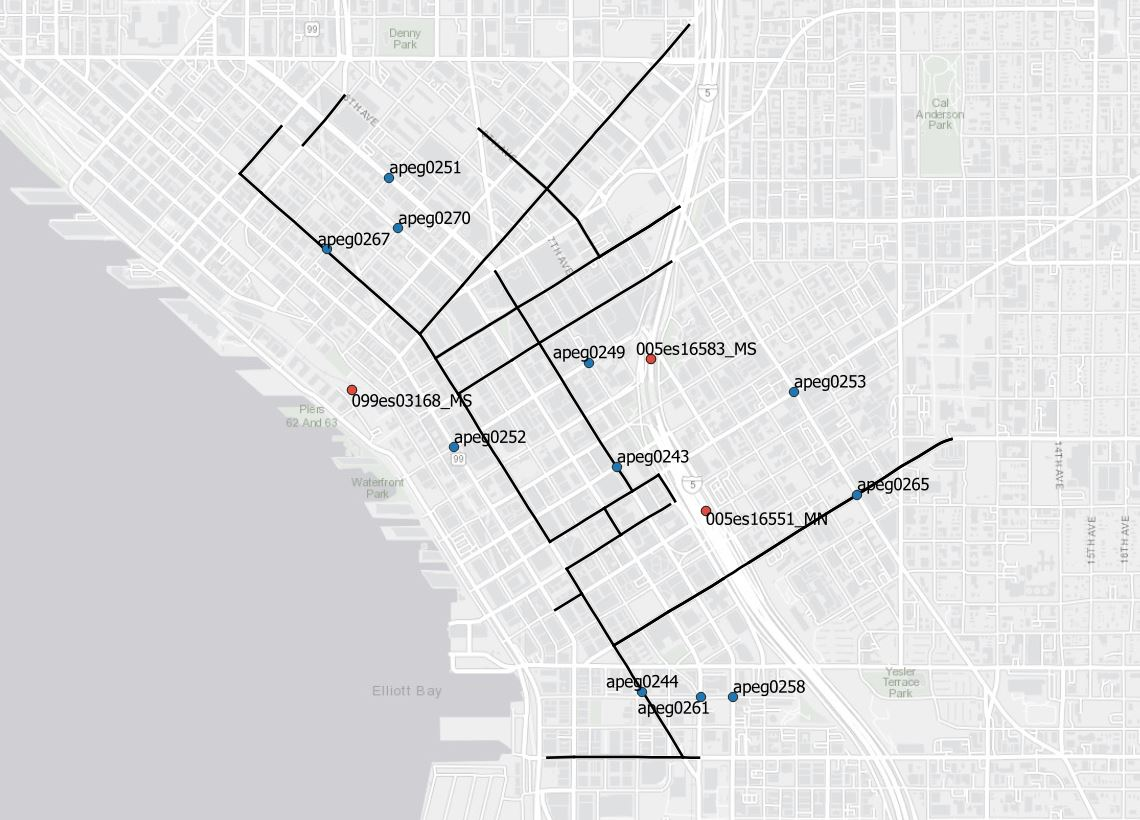

SUMO network 
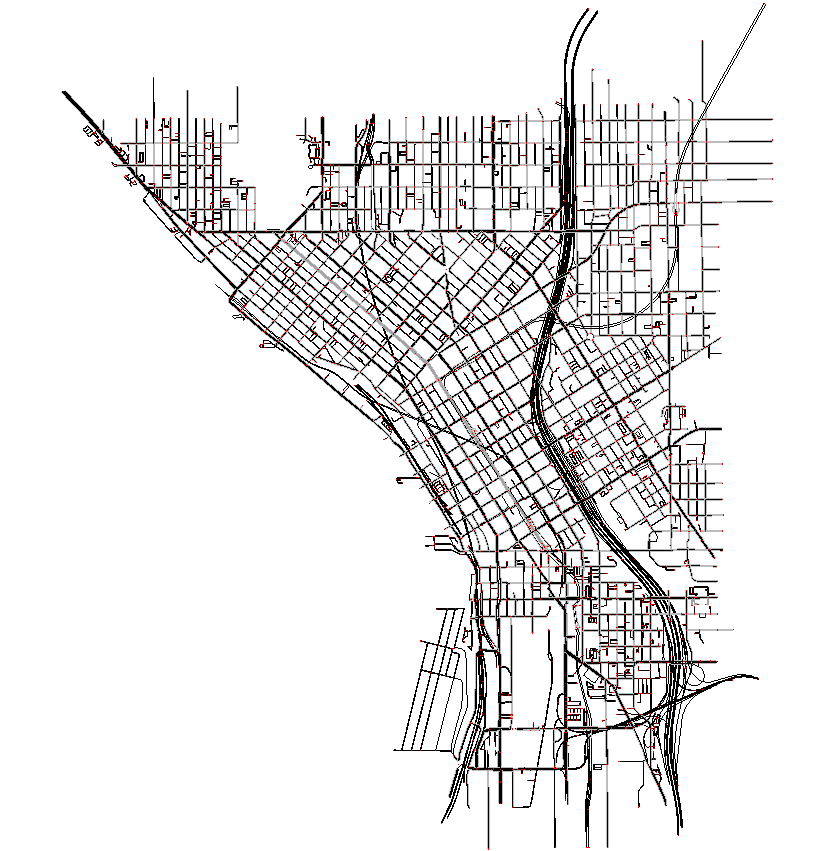

## Loop data processing

In [203]:
filepath = 'Traffic_vol/'
# get all the files under the given path
folders = os.listdir(filepath)
# check the zip file and unzip them all
for i in folders:
    if i[-3:] == 'zip' and 'Sensys' not in i:
        zip = ZipFile(filepath+i)
        zip.extractall(path=filepath)
        
#here we will only used avg vol for each loop sensys
selected_path = []
for i in os.listdir('Traffic_vol/'):
    if i[-6] == "m":
        selected_path.append('Traffic_vol/'+i)

for i in selected_path:
    dt_loop_vol = pd.read_excel(i, engine='openpyxl')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Traffic_vol/'

In [202]:
dt_test = pd.read_excel(selected_path[0], engine='openpyxl')
dt_test.head(10)

NameError: name 'selected_path' is not defined

In [7]:
test_loop_ids = list(dt_test.columns)[1:]
vol = np.ones((len(test_loop_ids), len(dt_test.index)))
for i in range(len(test_loop_ids)):
    vol[i] = dt_test[test_loop_ids[i]].values.T
    vol[i] = vol[i]/sum(vol[i])

In [8]:
vol = np.mean(vol, axis=0)
vol = vol/sum(vol)

In [9]:
np.round(vol,3)
a = ''
for i in np.round(vol,3):
    a = a+str(i)+','

In [10]:
def get_loop_avg(selected_hour, excel_path, loop_dict):
    #get loop direction
    loop_dir = str()
    for i in excel_path[12:].split(' ')[:2]:
        loop_dir = loop_dir+i
    loop_dict[loop_dir] = {}
    dt = pd.read_excel(excel_path, engine='openpyxl')
    
    loops_id = list(dt.columns)[1:]
    for loopid in loops_id:
        vol = list(dt.loc[selected_hour][loopid])        
        loop_dict[loop_dir][loopid] = sum(vol)/(np.count_nonzero(vol))
    return(loop_dict)

In [11]:
#define peak hour period
mor_peak = list(range(6,11))
eve_peak = list(range(15, 20))

In [12]:
loop_mor = {}
loop_eve = {}
for p in selected_path:
    loop_mor = get_loop_avg(mor_peak, p, loop_mor)
    loop_eve = get_loop_avg(eve_peak, p, loop_eve)

In [33]:
os.listdir()

['loop_eve_mor.csv',
 'pseudo_taz.csv',
 'selected_sensors_1.csv',
 'sumo_data_correlation.csv',
 'sumo_vol_cor.csv',
 'sumo_vol_cor_prev.csv',
 'Traffic_vol',
 'Travel_time',
 'veh_od_convert.csv',
 'veh_od_convert_Seattle_Bellevue.csv',
 'veh_od_psrc.csv']

In [139]:
dt = combine_mor_eve(loop_mor, loop_eve)
dt.to_csv('loop_eve_mor.csv')

In [141]:
dt.head()

,5N,5S,99N,99S,peak
164.0,3713.130612,6264.004516,NaN,NaN,mor
164.5,3247.928736,4994.477634,NaN,NaN,mor
165.0,4453.752490,3724.950753,NaN,NaN,mor
165.5,5299.003651,2455.423871,NaN,NaN,mor
166.0,5687.577191,4433.845818,NaN,NaN,mor


## Sensys data

In [138]:
#get sensys data loc
sensys_loc = pd.read_excel('Traffic_vol/Location Lat Long.xlsx', engine='openpyxl')
sensys_loc.head(3)

,Name,APEG,Screenline,Latitude,Longitude
0,Ballard Bridge,apeg0125,Flow Map,47.658978,-122.376148
1,SR 99 & S Lander St,apeg0225,NaN,47.579731,-122.339342
2,5th Ave & Spring St,apeg0243,NaN,47.607255,-122.332407


In [15]:
selected_sensys_path = []
for i in os.listdir('Traffic_vol/Sensys/'):
    selected_sensys_path.append('Traffic_vol/Sensys/'+i)


In [16]:
#check sensys data
dt_test = pd.read_csv(selected_sensys_path[0])
dt_test.head(3)

,Time,APEG,Sensor Zone,Occup (%),Vol,Speed med (mph),APEG.1,Sensor Zone.1,Occup (%).1,Vol.1,...,Sensor Zone.279,Occup (%).279,Vol.279,Speed med (mph).273,APEG.280,Sensor Zone.280,Occup (%).280,Vol.280,Speed med (mph).274,Unnamed: 1406
0,05/08/2018 00:00:00 PDT,apeg0125,0125S_NBT_1,0.52,51,38,apeg0125,0125S_NBT_2,4.31,97,...,sensorZone68,0.22,12,NaN,apeg6269,sensorZone75,0.97,73,NaN,NaN
1,05/08/2018 01:00:00 PDT,apeg0125,0125S_NBT_1,0.19,23,41,apeg0125,0125S_NBT_2,0.59,58,...,sensorZone68,0.31,17,NaN,apeg6269,sensorZone75,0.79,53,NaN,NaN
2,05/08/2018 02:00:00 PDT,apeg0125,0125S_NBT_1,0.32,22,43,apeg0125,0125S_NBT_2,0.49,35,...,sensorZone68,0.51,23,NaN,apeg6269,sensorZone75,1.16,72,NaN,NaN


In [17]:
# find volume corresponds to the sensys ids
def get_sensor_vol_relation(dt):
    colname = list(dt.columns)
    #get correspons sensor with vol symbol
    sensor_vol = {}
    for col in colname:
        if 'Sensor Zone' in col:
            if '.' not in col:
                sensor_vol[col] = 'Vol'
            else:
                sensor_vol[col] = 'Vol.'+ col.split('.')[1]
    sensors_dict = {}
        
    for col in colname:
        if 'Sensor Zone' in col:
            sensors = np.unique(dt[col])[0]
            if '_' in sensors:
                sensors = sensors.split('_')
                if len(sensors) >= 2:
                    sensors = sensors[0]+sensors[1]
                else:
                    print(sensors)
            if sensors not in sensors_dict:
                sensors_dict[sensors] = []
                sensors_dict[sensors].append(sensor_vol[col])
            else:
                sensors_dict[sensors].append(sensor_vol[col]) 
    return(sensors_dict)

#calculate the volume
def calculate_col(pathfile, vol_dict, hour_period):
    dt = pd.read_csv(pathfile)
    #from Tuesday and Thursday
    weekdays = [1,2,3]
    if datetime.strptime(dt['Time'][0][:-4],"%m/%d/%Y %H:%M:%S").weekday() in weekdays:
        sensor_dict = get_sensor_vol_relation(dt)
        if vol_dict == {}:
            for sensors in sensor_dict:
                vol_dict[sensors] = dt.loc[hour_period][sensor_dict[sensors]].values
        else:
            for sensors in sensor_dict:
                if sensors not in vol_dict:
                    vol_dict[sensors] = dt.loc[hour_period][sensor_dict[sensors]].values
                else:
                    vols = dt.loc[hour_period][sensor_dict[sensors]].values
                    vol_dict[sensors] = np.append(vol_dict[sensors], vols, axis=0)
    return(vol_dict)    

#calculate_vol_avg:
def calculate_avg_vol(vol_arr, sensys_id):
    #no zero/misssing values
    if len(np.unique(np.count_nonzero(vol_arr, axis=1))) == 1:
        edge_sum_vol = np.sum(vol_arr, axis=1)
        avg_vol = np.sum(edge_sum_vol)/len(edge_sum_vol)
        return(avg_vol)
    else:
        #calculate average for each lane and then add them up
        edge_sum_vol = np.sum(vol_arr, axis=0)
        
        num_data = np.count_nonzero(vol_arr, axis=0)
        avg_vol = np.sum(edge_sum_vol[np.nonzero(edge_sum_vol)]/num_data[np.nonzero(num_data)])
        return(avg_vol)

In [18]:
sensys_vol_dict_mor = {}
sensys_vol_dict_eve = {}

for path in selected_sensys_path:
    sensys_vol_dict_mor = calculate_col(path, sensys_vol_dict_mor, mor_peak)
    sensys_vol_dict_eve = calculate_col(path, sensys_vol_dict_eve, eve_peak)

In [175]:
sensys_vol_mor = {}
sensys_vol_eve = {}
sensys_vol = {}

for i in sensys_vol_dict_mor.keys():
    sensys_vol_mor[i] = calculate_avg_vol(sensys_vol_dict_mor[i], i)
    sensys_vol_eve[i] = calculate_avg_vol(sensys_vol_dict_eve[i], i)
    
sensys_vol['mor'] = sensys_vol_mor
sensys_vol['eve'] = sensys_vol_eve
sensys_vol = pd.DataFrame(sensys_vol)

In [176]:
null_sensor = []
for i in sensys_vol_mor.keys():
    if sensys_vol_mor[i] == 0 :
        if i[:4] not in null_sensor:
            if len(i) >= 4:
                null_sensor.append(i[:4])
            else:
                null_sensor.append(i)


In [177]:
#get sensors in downtown Seattle
selected_sensors = pd.read_csv('Traffic_vol/selected_sensors.csv')

non_available_ids = []
for sensorids in selected_sensors['APEG']:
    if sensorids[4:] in null_sensor:
        non_available_ids.append(sensorids)
selected_sensors = selected_sensors[selected_sensors['APEG']!=non_available_ids[0]]

selected_sensors.head(3)

,Name,APEG,Screenline,Latitude,Longitude
0,5th Ave & Spring St,apeg0243,NaN,47.607255,-122.332407
1,2nd Ave S & Washington St,apeg0244,NaN,47.601027,-122.331377
2,6th Ave & Union St,apeg0249,NaN,47.610141,-122.333560


In [178]:
#divide the direction for each sensor
sensors = list(selected_sensors['APEG'].values)

sensor_directions = {}
for i in sensys_vol_mor.keys():
    dir_keys = 'apeg'+i[:4]
    if len(i) >= 4 and dir_keys in sensors:
        if dir_keys not in sensor_directions:
            sensor_directions[dir_keys] = []
            sensor_directions[dir_keys].append(i[-3:])
        else:
            sensor_directions[dir_keys].append(i[-3:])

dir_labels = []
label = []
for i in sensors:
    if i in sensor_directions:
        if len(sensor_directions[i]) > 1:
            labels = i
            for j in sensor_directions[i]:
                labels = labels+'_'+j
        else:
            labels = i+'_'+sensor_directions[i][0]
        dir_labels.append(labels)
        label.append(1)
    else:
        dir_labels.append(i+'_no_dir')
        label.append(0)
        
selected_sensors['dir_label'] = dir_labels
selected_sensors['label'] = label

In [179]:
selected_sensors = selected_sensors[selected_sensors['label']==1]

In [180]:
selected_sensors.to_csv('selected_sensors_1')

In [181]:
del(sensys_vol_eve)
del(sensys_vol_mor)
sensys_vol.head()

,mor,eve
0125SNBT,1395.533333,2297.500000
0125SSBT,2079.000000,1887.733333
0243SSBT,553.833333,813.233333
0244SSBT,499.714493,759.261404
0249SNBT,374.333333,276.633333


In [183]:
sensys_vol.head(100)
sensys_vol.to_csv("sensys_vol_mor_eve.csv")

## NPMRDS data
considering processing through Tableau

In [26]:
path = 'Travel_time/'

In [27]:
travel_time_mor = pd.read_csv(path+'mor.csv')
travel_time_eve = pd.read_csv(path+"eve.csv")
travel_time = pd.merge(travel_time_mor, travel_time_eve)

del(travel_time_mor)
del(travel_time_eve)

## sumo data processing

In [28]:
#provide sumo xml file to read
#file_path = '../Edge_data_sb.xml'
file_paths = []
for files in os.listdir('../'):
    if 'Edge' and 'per.xml' in files:
        file_paths.append('../'+files)

In [29]:
file_paths

['../Edgetest_veh_od_psrc_wh20per.xml',
 '../Edge_veh_od_psrc_convert10per.xml',
 '../Edge_veh_od_psrc_convert15per.xml',
 '../Edge_veh_od_psrc_convert20per.xml',
 '../Edge_veh_od_psrc_convert25per.xml',
 '../Edge_veh_od_psrc_convert30per.xml',
 '../Edge_veh_od_psrc_convert35per.xml',
 '../Edge_veh_od_psrc_convert40per.xml',
 '../Edge_veh_od_psrc_convert45per.xml',
 '../Edge_veh_od_psrc_convert5per.xml',
 '../Edge_veh_od_psrc_wh10per.xml',
 '../Edge_veh_od_psrc_wh15per.xml',
 '../Edge_veh_od_psrc_wh20per.xml',
 '../Edge_veh_od_psrc_wh25per.xml',
 '../Edge_veh_od_psrc_wh30per.xml',
 '../Edge_veh_od_psrc_wh35per.xml',
 '../Edge_veh_od_psrc_wh40per.xml',
 '../Edge_veh_od_psrc_wh45per.xml',
 '../Edge_veh_od_psrc_wh5per.xml']

In [30]:
for i in tested_sensys_vol['index'].values:
    selected_sensys

NameError: name 'tested_sensys_vol' is not defined

In [ ]:
tested_travel_time['Tmc Code'].values

In [31]:
#read sumo data and check 
#get data from sumo.xml file
def read_xml_data(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    sumo_data = {}
    checked_value = {'entered':0, 'departed':0, 'arrived':0, 'left':0}
    #check enter, depart, arrive and left values
    for interval in root.findall('interval'):   
        begin_time = int(float(interval.get('begin'))/3600)
        #select mor peak only
        if begin_time>=7 and begin_time<10:
            end_time = int(float(interval.get('end'))/3600)
            time_period = str(begin_time)+'-'+str(end_time)
            #print collected time period
            #print(time_period)
            for edge in interval.findall('edge'):
                edgeid = edge.get('id')
                entered = float(edge.get('entered'))
                departed = float(edge.get('departed'))
                arrived = float(edge.get('arrived'))
                left = float(edge.get('left'))
                checked_val_cur = [entered, departed, arrived, left]
                checked_keys = list(checked_value.keys())
                for i in range(len(checked_val_cur)):
                    if checked_val_cur[i] > checked_value[checked_keys[i]]:
                        checked_value[checked_keys[i]] = checked_val_cur[i]

                if edgeid in test_sumoids:
                    if edgeid not in sumo_data:
                        sumo_data[edgeid] = {}
                        sumo_data[edgeid][time_period] = edge.attrib
                    else:
                        sumo_data[edgeid][time_period] = edge.attrib  

    print('check if any selected sumo id for calibration is missing from ' + file_path)
    missingids = []
    for sumoid in test_sumoids:
        if sumoid not in sumo_data.keys():
            print(sumoid)
            missingids.append(sumoid)
    print('missing info for calibration')
    if missingids != []:
        print(missingids)
    #connect_dt[['sensorid','dir']][connect_dt['sumoid'].isin(missingids)]

    #check travel time
    sumoid_tmc = selected_tmc['sumoid']
    travel_time_dt = {}
    mapped_sensor_index = []
    #get travel time for each road segment
    for tmc_segment in selected_tmcid:
        travel_time_dt[tmc_segment] = {}
        sumoids = selected_tmc[['sumoid']][selected_tmc['sensorid']==tmc_segment].values.T[0]
        for ids in sumoids:
            if ids not in missingids:
           # print(ids)
                for time in sumo_data[ids]:
                    if time not in travel_time_dt[tmc_segment]:
                        travel_time_dt[tmc_segment][time] = []
                        travel_time_dt[tmc_segment][time].append(float(sumo_data[ids][time]['traveltime']))
                    else:
                        travel_time_dt[tmc_segment][time].append(float(sumo_data[ids][time]['traveltime']))
            
                
    directions = selected_sensys['dir'].values.T
    for i in range(len(directions)):
        directions[i] = directions[i].upper()
    selected_sensors = selected_sensys['sensorid'].values.T
    for i in range(len(directions)):
        if 'es' not in selected_sensors[i]:
            mapped_sensor_index.append(selected_sensors[i][4:]+'S'+directions[i]+'T')
        else:
            mapped_sensor_index.append(selected_sensors[i])
    #print(selected_sensys['index'])
    #print(mapped_sensor_index)
    selected_sensys['index'] = mapped_sensor_index

    #get sensys volume for each intersection
    sensys_vol_dt = {}
    selected_sensors = selected_sensys['index'].values.T
    for sensys_id in selected_sensors:
        sensys_vol_dt[sensys_id] = {}
        sumoids = selected_sensys['sumoid'][selected_sensys['index']==sensys_id].values
        ## notice
        ## this condition could be deleted when rerun the sumo model
        for ids in sumoids:
            if ids not in missingids:
            #print(ids)
                for time in sumo_data[ids]:
                    if time not in sensys_vol_dt[sensys_id]:
                        sensys_vol_dt[sensys_id][time]={}
                        sensys_vol_dt[sensys_id][time]['vol_depart'] = []
                        sensys_vol_dt[sensys_id][time]['vol_depart_arrive'] = []
                        sensys_vol_dt[sensys_id][time]['vol_depart'].append(float(sumo_data[ids][time]['entered']))
                        sensys_vol_dt[sensys_id][time]['vol_depart_arrive'].append((float(sumo_data[ids][time]['entered'])+float(sumo_data[ids][time]['left']))/2)
                    else:
                        sensys_vol_dt[sensys_id][time]['vol_depart'].append(float(sumo_data[ids][time]['entered']))
                        sensys_vol_dt[sensys_id][time]['vol_depart_arrive'].append((float(sumo_data[ids][time]['entered'])+float(sumo_data[ids][time]['left']))/2)
    return(travel_time_dt, sensys_vol_dt) 

In [10]:
def calculate_hourly_travel_time(travel_time_dict):
    #convert dict to array
    time_keys = list(travel_time_dict.keys())

    row = len(travel_time_dict)
    
    data_len_time = []
    for time in time_keys:
        data_len_time.append(len(travel_time_dict[time]))
    
    if data_len_time != []:
        col = max(data_len_time)
    
        missing_index = []
        missing_time = []
        for i in range(len(data_len_time)):
            if data_len_time[i] != col:
                missing_index.append(i)
                missing_time.append(time_keys[i])

        if missing_index != []:
            for i in missing_time:
                time_keys.remove(i)  
        #print(time_keys)
        #print(len(time_keys))
        tt_arr = np.zeros((len(time_keys), col))
        j = -1
        for r in range(row):
            if r not in missing_index:
                j = j+1
                for c in range(col):
                    tt_arr[j][c] = travel_time_dict[time_keys[j]][c]       
            #calculate travel time
        return(np.mean(np.sum(tt_arr, axis=1)))
    if data_len_time == []:
        return(0)
    
    
def calculate_hourly_vol(vol_dict):
    if vol_dict == {}:
        return([None, None])
    else:
        time_keys = list(vol_dict.keys())
        vol_keys = list(vol_dict[time_keys[0]].keys())

        vol_mean = []

        for vol_key in vol_keys:
            row = len(time_keys)
            col = len(vol_dict[time_keys[0]][vol_key])
            cal_m = np.zeros((row, col))
            for r in range(row):
                for c in range(col):
                    cal_m[r][c] = vol_dict[time_keys[r]][vol_key][c]
            vol_mean.append(np.mean(np.sum(cal_m, axis=1)))
        return(vol_mean) 
    
def add_simulation_dt(id_order, simulation_data, cur_df, colname, vol_index = False):
    if vol_index == False:
        pass
    else:
        for i in range(len(id_order)):
            if 'L' in id_order[i]:
                id_order[i] = '0267SSBT'
    simulations_val = []
    for ids in id_order:
        simulations_val.append(simulation_data[ids])
    cur_df[colname] = simulations_val
    return(cur_df)

def get_GEH(true, simulated):
    E = simulated
    V = true
    GEH = (E-V)**2/((E+V)/2)
    return(GEH)

def get_validation_criteria(true, simulated, road_seg, filepath):
    #plt.hist([true, simulated],label=['true','simulated'])
    validate_road = []
    criteria = []
    
    #calculate GEH
    GEH = get_GEH(true, simulated)
    
    minus = simulated-true
    for i in range(len(true)):
        if abs(GEH[i]) <= 0.15:
            criteria.append(1)
            validate_road.append(road_seg[i])
            #print('GEH', road_seg[i], abs(GEH[i]))
        elif abs(minus[i]) <= 60:
            criteria.append(1)
            validate_road.append(road_seg[i])
            #print('minus', road_seg[i], abs(minus[i]))
        else:
            criteria.append(0)
    print('road satisfy validation criteria from '+filepath+': ', (len(validate_road)/len(road_seg)))
    print('# of tested road segments: ', len(selected_tmcid))
    return(criteria, GEH)

def get_validation_criteria_vol(true, simulated, sensorid, filepath):
    #plt.hist([true, simulated],label=['true','simulated'])
    validate_sensor = []
    criteria = []
    
    GEH = get_GEH(true, simulated)
    
    for i in range(len(true)):
        if abs(GEH[i]) <= 0.15:
            criteria.append(1)
            validate_sensor.append(sensorid[i])
            #print('GEH', sensorid[i], abs(GEH[i]-1))
        else:
            criteria.append(0)
    print('road satisfy validation criteria vol from '+filepath+': ', (len(validate_sensor)/len(sensorid)))
    print('number of tested intersections: ', len(selected_sensors))
    return(criteria, GEH)

In [33]:
for tmcid in selected_tmcid:
    if tmcid not in travel_time_dt:
        print(tmcid)

NameError: name 'selected_tmcid' is not defined

In [145]:
selected_sensors = list(sensys_vol_dt.keys())

NameError: name 'sensys_vol_dt' is not defined

In [146]:
def add_simulation_data(travel_time_dt, sensys_vol_dt, colname, col_crit, col_geh, filepath, tested_travel_time, tested_sensys_vol, loopdt):
    simulation_data = {'tt':{}, 'vol':{},'vol/2':{}}
    for tmcid in selected_tmcid: 
        simulation_data['tt'][tmcid] = calculate_hourly_travel_time(travel_time_dt[tmcid])

    vollst = []
    selected_sensors = list(sensys_vol_dt.keys())
    for sensorid in selected_sensors:
        vollst = calculate_hourly_vol(sensys_vol_dt[sensorid])
        simulation_data['vol'][sensorid] = vollst[0]
        simulation_data['vol/2'][sensorid] = vollst[1]    

    #compare the data with the current dataset
    #map the tmc
    tmcids = list(np.unique(tested_travel_time['Tmc Code']))
    sensor_ids = list(np.unique(tested_sensys_vol['index']))
    loop_ids = list(np.unique(loopdt['loopid']))

    tested_travel_time = add_simulation_dt(tmcids, simulation_data['tt'], tested_travel_time, colname, False)
    tested_sensys_vol = add_simulation_dt(sensor_ids, simulation_data['vol'], tested_sensys_vol, colname, True)
    loopdt = add_simulation_dt(loop_ids, simulation_data['vol'], loopdt, colname, False)
    
    #caclulate travel time criteria
    true = tested_travel_time['mor'].values.T
    simulated = tested_travel_time[colname].values.T
    road_seg = tested_travel_time['Tmc Code'].values.T
    
    tested_travel_time[col_crit], tested_travel_time[col_geh] = get_validation_criteria(true, simulated, road_seg, filepath)
    
    
    #caclulate traffic volumn criteria
    true = tested_sensys_vol['mor'].values.T
    simulated = tested_sensys_vol[colname].values.T

    tested_sensys_vol[col_crit],tested_sensys_vol[col_geh] = get_validation_criteria_vol(true, simulated, sensor_ids, filepath)
    
    true = loopdt['mor'].values.T
    simulated = loopdt[colname].values.T

    loopdt[col_crit], loopdt[col_geh] = get_validation_criteria_vol(true, simulated, sensor_ids, filepath)
    
    return(tested_travel_time, tested_sensys_vol, loopdt)


In [36]:
os.listdir()
selected_data = []
for i in os.listdir():
    if '_convert' in i and 'per' in i:
        selected_data.append(i)

In [182]:
selected_data

[]

In [147]:
selected_sensors

,Name,APEG,Screenline,Latitude,Longitude,dir_label,label
0,5th Ave & Spring St,apeg0243,NaN,47.607255,-122.332407,apeg0243_SBT,1
1,2nd Ave S & Washington St,apeg0244,NaN,47.601027,-122.331377,apeg0244_SBT,1
2,6th Ave & Union St,apeg0249,NaN,47.610141,-122.333560,apeg0249_NBT,1
3,5th Ave & Blanchard St,apeg0251,NaN,47.615262,-122.341757,apeg0251_SBT,1
4,1st Ave & Union St,apeg0252,NaN,47.607798,-122.339102,apeg0252_NBT_SBT,1
5,Boren Ave & Madison St,apeg0253,NaN,47.609331,-122.325138,apeg0253_EBT_WBT,1
6,5th Ave S & Washington St,apeg0258,NaN,47.600882,-122.327643,apeg0258_NBT_SBT,1
7,4th Ave S & Washington St,apeg0261,NaN,47.600882,-122.328974,apeg0261_NBT,1
9,Boren Ave & James St,apeg0265,NaN,47.606486,-122.322544,apeg0265_EBT_WBT,1
11,2nd Ave & Blanchard St,apeg0267,NaN,47.613273,-122.344332,apeg0267_SBL_SBL_SBT,1


In [39]:
selected_data[0].split('_')[-1].split('.')[0][-5:]

IndexError: list index out of range

In [148]:
for pathfile in selected_data:
    travel_time_dt, sensys_vol_dt = read_xml_data(pathfile)
    colname = 'test_'+pathfile.split('_')[-1].split('.')[0][-5:]
    col_crit = colname+'_'+'crit'
    col_geh = colname+'_'+'geh'
    tested_travel_time, tested_sensys_vol, loopdt = add_simulation_data(travel_time_dt, sensys_vol_dt, colname, col_crit,\
                                                                        col_geh, files, tested_travel_time,\
                                                                       tested_sensys_vol, loopdt)

In [149]:
tested_sensys_vol.columns

NameError: name 'tested_sensys_vol' is not defined

In [ ]:
sensorids

In [ ]:
sensorid = list(sensorids[:-6])
sensorid.append(sensorid[-1])
sensorid.append(sensorid[-1])

In [ ]:
tested_sensys_vol['sensorid']=sensorid

In [ ]:
tested_sensys_vol[['sensorid','mor', 'test_t5per','test_10per','test_15per','test_20per']]

In [ ]:
with open('G:\Shared drives\SUMO Seattle Simulation Model\Seattle Network\Bigger Seattle\Traffic signal\test\test_network_with_transit_n_veh_ped\Edge_veh_od_psrc_convert15per.xml') as f:
    print(f.readline())

In [ ]:
tested_travel_time[['mor','test_t5per','test_10per','test_15per','test_20per']]

In [ ]:
for files in file_paths:
    travel_time_dt, sensys_vol_dt = read_xml_data(files)
    colname = files.split('_')[-1][:-4]
    col_crit = colname+'_'+'crit'
    col_geh = colname+'_'+'geh'
    tested_travel_time, tested_sensys_vol, loopdt = add_simulation_data(travel_time_dt, sensys_vol_dt, colname, col_crit,\
                                                                        col_geh, files, tested_travel_time,\
                                                                       tested_sensys_vol, loopdt)
   

In [ ]:
check_val = []
check_val.append('Tmc Code')
check_val.append('mor')
for i in loopdt.columns:
    if 'per' in i and '_' not in i:
        check_val.append(i)

tested_travel_time[check_val]

In [ ]:
check_val = []
check_val.append('Tmc Code')
for i in loopdt.columns:
    if 'per' in i and 'crit' in i:
        check_val.append(i)
tested_travel_time[check_val]

In [ ]:
check_val = []
check_val.append('mor')
for i in loopdt.columns:
    if 'per' in i and '_' not in i:
        check_val.append(i)
loopdt[check_val]

In [ ]:
tested_sensys_vol[check_val]

## Simulation test summary with multiple ods

| tested od | % of travel time matched criteria | % of vol matched criteria |
| --- | --- | --- |
| no external od | 56.25 | 0 |
| all od from psrc | 0 | 0 |
| all work-home od from psrc | 5 | 0 |
| all od from Seattle & Bellevue | 0 | 5 |
| work-home od from Seattle & bellevue | 53.125 | 0 |

## revise OD data

In [15]:
os.listdir()

['.ipynb_checkpoints',
 'Bigger_Seattle_multi_modes_withsignal_convert.sumocfg',
 'Bigger_Seattle_veh_convert_test.rou.xml',
 'bus_link_route.rou.xml',
 'data_extract.py',
 'data_for_calibration',
 'data_processing_sumo.ipynb',
 'Edgetest_.xml',
 'Edgetest_onvert.xml',
 'Edgetest_veh_od_psrc_wh20per.xml',
 'edge_data.add.xml',
 'Edge_veh_od_psrc_convert10per.xml',
 'Edge_veh_od_psrc_convert15per.xml',
 'Edge_veh_od_psrc_convert20per.xml',
 'Edge_veh_od_psrc_convert25per.xml',
 'Edge_veh_od_psrc_convert30per.xml',
 'Edge_veh_od_psrc_convert35per.xml',
 'Edge_veh_od_psrc_convert40per.xml',
 'Edge_veh_od_psrc_convert45per.xml',
 'Edge_veh_od_psrc_convert5per.xml',
 'Edge_veh_od_psrc_wh10per.xml',
 'Edge_veh_od_psrc_wh15per.xml',
 'Edge_veh_od_psrc_wh20per.xml',
 'Edge_veh_od_psrc_wh25per.xml',
 'Edge_veh_od_psrc_wh30per.xml',
 'Edge_veh_od_psrc_wh35per.xml',
 'Edge_veh_od_psrc_wh40per.xml',
 'Edge_veh_od_psrc_wh45per.xml',
 'Edge_veh_od_psrc_wh5per.xml',
 'generate_rou.py',
 'input_output

In [16]:
#psrc_od
len(pd.read_csv('veh_od_convert.csv').index)

FileNotFoundError: [Errno 2] No such file or directory: 'veh_od_convert.csv'

In [7]:
#assign value to specific od
def label_specific_od(dt_psrc, selected_taz, new_colname):
    ori = []
    for origin in dt_psrc['otaz']:
        if origin in selected_taz:
            ori.append(1)
        else:
            ori.append(-1)
    dest = []
    for destination in dt_psrc['dtaz']:
        if destination in selected_taz:
            dest.append(1)
        else:
            dest.append(-1)

    dt_psrc[new_colname[0]] = ori
    dt_psrc[new_colname[1]] = dest
    dt_psrc[new_colname[2]] = dt_psrc[new_colname[0]]+dt_psrc[new_colname[1]]
    return(dt_psrc)

#define a function to save od csv
def get_od_csv(mode_type, savepath, csvname, dt_psrc, savefile=True):
    dt_od = dt_psrc[['otaz','dtaz']][dt_psrc['decode']==mode_type]
    #get ods
    od = {}
    dt_od = dt_od.reset_index()
    for i in range(len(dt_od['otaz'])):
        odpair = str(dt_od['otaz'][i])+'_'+str(dt_od['dtaz'][i])
        if odpair not in od:
            od[odpair] = 1
        else:
            od[odpair] = od[odpair]+1
    if savefile==True:
        f = open(savepath+csvname, 'w')
        f.write('O, D, demand\n')
        for k in od:
            line = k.split('_')
            line.append(str(od[k]))
            line = ", ".join(line)
            f.write(line+'\n')
        f.close()
        print('convert to '+csvname+' done')
    else:
        return(od)

#read and revise od data
#read .tsv file
#path = 'G:/My Drive/2020/sumo/2014/'
path="C:\\Users\\guoqq17\\Desktop\\C2Smart\\SUMO calibration\\data_source" 
os.chdir(path)
dt_psrc = pd.read_csv('_trip.tsv', header = 0, sep='\t')



In [90]:
#get information we need
#get taz file
pathfile = 'C:/Users/guoqq17/Desktop/C2Smart/SUMO calibration/sumo_network_test'
os.chdir(pathfile)
datapath = '../Taz_bigger_Seattle_all_transit.add.xml'
tree = ET.parse(datapath)
root = tree.getroot()
selected_taz = []
for taz in root.findall('taz'):
    tazid = taz.get('id')
    selected_taz.append(tazid)
    
for i in range(len(selected_taz)):
    selected_taz[i] = int(selected_taz[i])
selected_taz

[426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 442,
 443,
 446,
 447,
 448,
 450,
 451,
 452,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 460,
 461,
 462,
 463,
 464,
 465,
 466,
 467,
 468,
 469,
 470,
 471,
 472,
 473,
 474,
 475,
 476,
 477,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 566,
 567,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 627,
 628,
 629,
 630,
 631,
 632,
 634,
 635,
 636,
 650,
 651,
 652

In [ ]:
#conver dt_psrc_files
#select people opurp is home or is work
mode_keys = {1:'walk',2:'bike',3:'sov',4:'hov',5:'hov3+',6:'walk to transit',8:'school bus',0:'other'}
dt_psrc = dt_psrc[['otaz', 'dtaz', 'mode', 'opurp','dpurp']]

#dt_od = np.array(dt_psrc)
decode_mode = []
for mode_id in dt_psrc['mode']:
    #ped
    if mode_id == 1:
        decode_mode.append(1)
    #ped to transit
    elif mode_id == 6:
        decode_mode.append(2)
    #bike
    elif mode_id == 2:
        decode_mode.append(3)
    #veh
    elif mode_id in [3, 4, 5]:
        decode_mode.append(4)
    #other
    elif mode_id == 8:
        decode_mode.append(5)
    else:
        #print(mode_id)
        decode_mode.append(0)
        
dt_psrc['decode'] = decode_mode

In [ ]:
dt_psrc.head(3)

In [ ]:
dt_psrc_wh = dt_psrc[(dt_psrc['opurp'].isin([0,1])) & (dt_psrc['dpurp'].isin([0,1]))]

In [ ]:
#select od within downtown Seattle region
#select id
'''ori = []
for origin in dt_psrc['otaz']:
    if origin in selected_taz:
        ori.append(1)
    else:
        ori.append(-1)
dest = []
for destination in dt_psrc['dtaz']:
    if destination in selected_taz:
        dest.append(1)
    else:
        dest.append(-1)

dt_psrc['ori_id'] = ori
dt_psrc['dest_id'] = dest
dt_psrc['od'] = dt_psrc['ori_id']+dt_psrc['dest_id']'''

newcol = ['ori_id','dest_id','od']
dt_psrc = label_specific_od(dt_psrc, selected_taz, newcol)

dt_psrc_wh = label_specific_od(dt_psrc_wh, selected_taz, newcol)
#get od paid within the selected taz id
#select od which origin and dest both from downtown Seattle
#dt_psrc = dt_psrc[dt_psrc['od']==2]

In [ ]:
#save csv file
#get_od_csv(4, 'G:/Shared drives/SUMO Seattle Simulation Model/Seattle Network/Bigger Seattle/Traffic signal/test/test_network_with_transit_n_veh_ped/data_for_calibration/', 'veh_od_psrc.csv')

In [ ]:
dt_psrc_wh.head(3)

In [ ]:
#delete ods of which origin and destination not in tazs
dt_psrc = dt_psrc[dt_psrc['od']!=-2]
dt_psrc_wh = dt_psrc_wh[dt_psrc_wh['od']!=-2]
dt_psrc.head(3)

In [ ]:
#check if we have missing values
#read the Seattle and Bellevue taz data
Seattle_Bellevue_taz = pd.read_csv('../Seattle_Bellevue_region.csv')
Seattle_Bellevue_taz = Seattle_Bellevue_taz['TAZ'].values.T 

#ori_SB --> ori from Seattle and Bellevue
newcol = ['ori_sb','dest_sb','od_sb']
dt_psrc = label_specific_od(dt_psrc, Seattle_Bellevue_taz, newcol)

dt_psrc_wh = label_specific_od(dt_psrc_wh, Seattle_Bellevue_taz, newcol)

In [ ]:
#focus only on Seattle and Bellevue area
dt_psrc = dt_psrc[dt_psrc['od_sb']==2]

#focus only on work/home od from Seattle Bellevue are
dt_psrc_wh_sb = dt_psrc_wh[dt_psrc_wh['od_sb']==2]

In [ ]:
get_od_csv(4, '../', 'veh_od_psrc_Seattle_Bellevue.csv', dt_psrc, True)
get_od_csv(4, '../', 'veh_od_psrc_wh.csv', dt_psrc_wh, True)
get_od_csv(4, '../', 'veh_od_psrc_wh_Seattle_Bellevue.csv', dt_psrc_wh_sb, True)

In [ ]:
get_od_csv(4, '../', 'veh_od_psrc.csv', dt_psrc, True)

In [ ]:
#check missings
def check_miss(filepath):
    psrc_ods = pd.read_csv(filepath)
    psrc_ods.columns = ['O','D','demand']
    #check if number of tazs regarding origins and destinations
    print(len(np.unique(psrc_ods['O'])))
    print(len(np.unique(psrc_ods['D'])))
    #check if we have missing values
    print(psrc_ods[psrc_ods['demand']==0])

In [ ]:
check_miss('../veh_od_psrc_Seattle_Bellevue.csv')
check_miss('../veh_od_psrc_wh.csv')
check_miss('../veh_od_psrc_wh_Seattle_Bellevue.csv')

In [233]:
test = gpd.read_file('../taz2010.shp').to_crs("EPSG:4326")
test

,TAZ,COUNTY_FIP,COUNTY_NM,geometry
0,1,033,King,"POLYGON ((-122.36096 47.72735, -122.36096 47.7..."
1,2,033,King,"POLYGON ((-122.35557 47.72505, -122.35556 47.7..."
2,3,033,King,"POLYGON ((-122.35559 47.73413, -122.35427 47.7..."
3,4,033,King,"POLYGON ((-122.35033 47.72779, -122.34955 47.7..."
4,5,033,King,"POLYGON ((-122.33560 47.72930, -122.33423 47.7..."
...,...,...,...,...
3695,3696,035,Kitsap,"POLYGON ((-122.56476 47.64307, -122.56445 47.6..."
3696,3697,035,Kitsap,"POLYGON ((-122.57080 47.62863, -122.57066 47.6..."
3697,3698,035,Kitsap,"POLYGON ((-122.54140 47.62142, -122.54132 47.6..."
3698,3699,035,Kitsap,"POLYGON ((-122.52481 47.61927, -122.52125 47.6..."


In [ ]:
check_miss('../veh_od_psrc.csv')

In [44]:
#other data processing
#get downtown Seattle taz in sumo
#get information we need

#read taz data
psrc_taz = gpd.read_file('../taz2010.shp').to_crs("EPSG:4326")

#get centroid points from taz
lat_psrc = []
lon_psrc = []
for polys in psrc_taz['geometry'].values:
    p = wkt.loads(str(polys))
    latlon = p.centroid.wkt
    latlon = latlon[5:].split(' ')
    lon = float(latlon[1][1:])
    lat = float(latlon[2][:-1])
    lat_psrc.append(lat)
    lon_psrc.append(lon)

psrc_taz['lat'] = lat_psrc
psrc_taz['lon'] = lon_psrc

#psrc_taz['lat'] = psrc_taz['lat']/10000
#psrc_taz['lon'] = psrc_taz['lon']/10000
psrc_taz.head(3)

,TAZ,COUNTY_FIP,COUNTY_NM,geometry,lat,lon
0,1,033,King,"POLYGON ((-122.36096 47.72735, -122.36096 47.7...",47.726942,-122.392753
1,2,033,King,"POLYGON ((-122.35557 47.72505, -122.35556 47.7...",47.728688,-122.358265
2,3,033,King,"POLYGON ((-122.35559 47.73413, -122.35427 47.7...",47.731244,-122.350285


In [225]:
#select taz only in Seattle Bellevue region
#psrc_taz = psrc_taz[psrc_taz['TAZ'].isin(selected_Seattle_Bellvue)]
psrc_taz[(psrc_taz['TAZ']==168)]

,TAZ,COUNTY_FIP,COUNTY_NM,geometry,lat,lon
167,168,033,King,"POLYGON ((1265517.019 251625.625, 1265516.045 ...",25.228589,126.488966


In [91]:
#load the pseudo taz

pseudo_taz = pd.read_csv('C:/Users/guoqq17/Desktop/C2Smart/SUMO calibration/sumo_network_test/data_for_calibration/pseudo_taz.csv')
pseudo_taz

,pseudo_id,location
0,5000,I-5Nin
1,5001,I-5Nout
2,5002,I-5Sin
3,5003,I-5Sout
4,5004,I-90in
5,5005,I-90out
6,5006,Eastin
7,5007,Eastout
8,5008,SR-99Sin
9,5009,SR-99Sout


In [159]:
[395, 396, 397, 398] in sumo_taz

NameError: name 'sumo_taz' is not defined

In [5]:
#aggreagate taz
def check_taz_ids(ids, sumo_taz):
    return(ids in sumo_taz)

def assign_to_taz(taz, assigned_taz, taz_map, sumo_taz):
    for i in taz:
        if check_taz_ids(i, sumo_taz) == True:
            print('warning, taz already in sumo')
        else:
            if i not in taz_map:
                taz_map[i] = assigned_taz
    return(taz_map)

def convert_od_file(filepath, psrc_taz):
    psrc_ods = pd.read_csv(filepath)
    psrc_ods.columns = ['O','D','demand']
    convert_od(psrc_ods, psrc_taz)
    
def convert_od(psrc_ods, psrc_taz):
    # for nearby north and south taz
    # aggregate their neighbor taz to them
    #since the demand from the ferry is not very  much (< 25 per od pair)
    #we exclud the ferry demand
    excluded_ferry_taz = [445, 449, 478, 610, 633]
    #check the demand
    #for i in excluded_ferry_taz:
    #    print(i)
    #    print(np.sum(psrc_ods['demand'][psrc_ods['D']==i].values))
    #    print(np.sum(psrc_ods['demand'][psrc_ods['O']==i].values))

    psrc_ods = psrc_ods[~psrc_ods['O'].isin(excluded_ferry_taz)]
    psrc_ods = psrc_ods[~psrc_ods['D'].isin(excluded_ferry_taz)]

    datapath = '../Taz_bigger_Seattle_all_transit_with_pseudo_link.add.xml'
    tree = ET.parse(datapath)
    root = tree.getroot()
    sumo_taz = []
    for taz in root.findall('taz'):
        tazid = taz.get('id')
        sumo_taz.append(tazid)
    
    #create taz map
    taz_map = {}
    
    #print('checkids')
    taz_map = assign_to_taz([444], 446, taz_map, sumo_taz)
    taz_map = assign_to_taz([395, 396, 397, 398], 442, taz_map, sumo_taz)
    taz_map = assign_to_taz([399, 400], 440, taz_map, sumo_taz)
    taz_map = assign_to_taz([401, 402], 436, taz_map, sumo_taz)
    taz_map = assign_to_taz([403], 434, taz_map, sumo_taz)
    taz_map = assign_to_taz([405], 432, taz_map, sumo_taz)
    taz_map = assign_to_taz([407], 427, taz_map, sumo_taz)
    taz_map = assign_to_taz([408], 426, taz_map, sumo_taz)
    taz_map = assign_to_taz([633], 610, taz_map, sumo_taz)
    taz_map = assign_to_taz([655], 653, taz_map, sumo_taz)
    taz_map = assign_to_taz([656], 652, taz_map, sumo_taz)
    taz_map = assign_to_taz([657], 650, taz_map, sumo_taz)
    #print('manual check end')

    #convert sumotaz to int
    for i in range(len(sumo_taz)):
        if 'taz' not in sumo_taz[i]:
            sumo_taz[i] = int(sumo_taz[i])

    reassigned_taz = list(taz_map.keys())
    sumo_taz.extend(reassigned_taz)
    
    pseudo_loc = pseudo_taz['location'].values.T
    pseudotazs = pseudo_taz['pseudo_id'].values.T
    pseudo_mapping = {}
    for i in range(int(len(pseudo_loc)/2)):
        index_num = i*2
        loc = pseudo_loc[index_num][:-2]
        pseudo_mapping[loc] = []
        pseudo_mapping[loc].append(pseudotazs[i*2])
        pseudo_mapping[loc].append(pseudotazs[i*2+1])
    
    psrc_taz = psrc_taz[~psrc_taz['TAZ'].isin(excluded_ferry_taz)]
    lat_val = psrc_taz['lat'].values.T
    lon_val = psrc_taz['lon'].values.T
    tazs = psrc_taz['TAZ'].values.T
    
    #set up criteria to identify variables
    #for lat, the larger, the higher; for lon, the larger, the more right
    SR99N = [23.421669, 126.923911]
    I5N = [23.268797,  126.923911]
    East = [[23.102587, 128.492278],[22.09419, 128.492278]]
    I90 = [[21.981049, 127.666997],[14.21359,145.35695]]
    SR99S = [[21.367705, 126.803996],[16.068982,127.22979]]
    
    for i in range(len(tazs)):
        if tazs[i] not in sumo_taz:
            #sr99N
            if lat_val[i]>= SR99N[0] and lon_val[i]<=SR99N[1]:
                taz_map[tazs[i]] = 'SR-99N'
            #I5N
            elif lat_val[i]>= I5N[0] and lon_val[i]>=I5N[1]:
                taz_map[tazs[i]] = 'I-5N'
            #East
            elif lat_val[i]<=East[0][0] and lat_val[i]>=East[1][0] and lon_val[i]<=East[0][1]:
                taz_map[tazs[i]] = 'East'
            elif lat_val[i]<=I90[0][0] and lat_val[i]>=I90[1][0] and lon_val[i]>=I90[0][1] and lon_val[i]<=I90[1][1]:
                taz_map[tazs[i]] = 'I-90'
            elif lat_val[i]<=SR99S[0][0] and lat_val[i]>=SR99S[1][0] and lon_val[i]>=SR99S[0][1] and lon_val[i]<=SR99S[1][1]:
                taz_map[tazs[i]] = 'SR-99S'
            else:
                taz_map[tazs[i]] = 'I-5S'

    psrc_ods = psrc_ods[psrc_ods['O'].isin(tazs)]
    psrc_ods = psrc_ods[psrc_ods['D'].isin(tazs)]
    
    #convert od files
    ori = psrc_ods['O'].values.T
    dest = psrc_ods['D'].values.T

    convert_ori = []
    convert_dest = []
    convert_taz = list(taz_map.keys())

    for i in range(len(ori)):
        if ori[i] in convert_taz:
            mapped_dir = taz_map[ori[i]]
            if type(mapped_dir) == int:
                convert_ori.append(mapped_dir)
            else:
                convert_ori.append(pseudo_mapping[mapped_dir][0])
        else:
            convert_ori.append(ori[i])

        if dest[i] in convert_taz:
            mapped_dir = taz_map[dest[i]]
            if type(mapped_dir) == int:
                convert_dest.append(mapped_dir)
            else:
                convert_dest.append(pseudo_mapping[mapped_dir][1])
        else:
            convert_dest.append(dest[i])
            
    psrc_ods['cO'] = convert_ori
    psrc_ods['cD'] = convert_dest
    
    return(psrc_ods)

In [45]:

pseudo_taz = pd.read_csv('C:/Users/guoqq17/Desktop/C2Smart/SUMO calibration/sumo_network_test/data_for_calibration/pseudo_taz.csv')
# for nearby north and south taz
# aggregate their neighbor taz to them
#since the demand from the ferry is not very  much (< 25 per od pair)
#we exclud the ferry demand
excluded_ferry_taz = [445, 449, 478, 610, 633]
#check the demand
#for i in excluded_ferry_taz:
#    print(i)
#    print(np.sum(psrc_ods['demand'][psrc_ods['D']==i].values))
#    print(np.sum(psrc_ods['demand'][psrc_ods['O']==i].values))

psrc_ods = psrc_ods[~psrc_ods['O'].isin(excluded_ferry_taz)]
psrc_ods = psrc_ods[~psrc_ods['D'].isin(excluded_ferry_taz)]

datapath = '../Taz_bigger_Seattle_all_transit_with_pseudo_link.add.xml'
tree = ET.parse(datapath)
root = tree.getroot()
sumo_taz = []
for taz in root.findall('taz'):
    tazid = taz.get('id')
    sumo_taz.append(tazid)

#create taz map
taz_map = {}

#print('checkids')
taz_map = assign_to_taz([444], 446, taz_map, sumo_taz)
taz_map = assign_to_taz([395, 396, 397, 398], 442, taz_map, sumo_taz)
taz_map = assign_to_taz([399, 400], 440, taz_map, sumo_taz)
taz_map = assign_to_taz([401, 402], 436, taz_map, sumo_taz)
taz_map = assign_to_taz([403], 434, taz_map, sumo_taz)
taz_map = assign_to_taz([405], 432, taz_map, sumo_taz)
taz_map = assign_to_taz([407], 427, taz_map, sumo_taz)
taz_map = assign_to_taz([408], 426, taz_map, sumo_taz)
taz_map = assign_to_taz([633], 610, taz_map, sumo_taz)
taz_map = assign_to_taz([655], 653, taz_map, sumo_taz)
taz_map = assign_to_taz([656], 652, taz_map, sumo_taz)
taz_map = assign_to_taz([657], 650, taz_map, sumo_taz)
#print('manual check end')

#convert sumotaz to int
for i in range(len(sumo_taz)):
    if 'taz' not in sumo_taz[i]:
        sumo_taz[i] = int(sumo_taz[i])

reassigned_taz = list(taz_map.keys())
sumo_taz.extend(reassigned_taz)

pseudo_loc = pseudo_taz['location'].values.T
pseudotazs = pseudo_taz['pseudo_id'].values.T
pseudo_mapping = {}
for i in range(int(len(pseudo_loc)/2)):
    index_num = i*2
    loc = pseudo_loc[index_num][:-2]
    pseudo_mapping[loc] = []
    pseudo_mapping[loc].append(pseudotazs[i*2])
    pseudo_mapping[loc].append(pseudotazs[i*2+1])


sumo_taz_dict = {k:k for k in sumo_taz}
psrc_taz['new_taz']=psrc_taz['TAZ'].map(sumo_taz_dict)


x="""    
psrc_taz = psrc_taz[~psrc_taz['TAZ'].isin(excluded_ferry_taz)]
lat_val = psrc_taz['lat'].values.T
lon_val = psrc_taz['lon'].values.T
tazs = psrc_taz['TAZ'].values.T

#set up criteria to identify variables
#for lat, the larger, the higher; for lon, the larger, the more right
SR99N = [23.421669, 126.923911]
I5N = [23.268797,  126.923911]
East = [[23.102587, 128.492278],[22.09419, 128.492278]]
I90 = [[21.981049, 127.666997],[14.21359,145.35695]]
SR99S = [[21.367705, 126.803996],[16.068982,127.22979]]

for i in range(len(tazs)):
    if tazs[i] not in sumo_taz:
        #sr99N
        if lat_val[i]>= SR99N[0] and lon_val[i]<=SR99N[1]:
            taz_map[tazs[i]] = 'SR-99N'
        #I5N
        elif lat_val[i]>= I5N[0] and lon_val[i]>=I5N[1]:
            taz_map[tazs[i]] = 'I-5N'
        #East
        elif lat_val[i]<=East[0][0] and lat_val[i]>=East[1][0] and lon_val[i]<=East[0][1]:
            taz_map[tazs[i]] = 'East'
        elif lat_val[i]<=I90[0][0] and lat_val[i]>=I90[1][0] and lon_val[i]>=I90[0][1] and lon_val[i]<=I90[1][1]:
            taz_map[tazs[i]] = 'I-90'
        elif lat_val[i]<=SR99S[0][0] and lat_val[i]>=SR99S[1][0] and lon_val[i]>=SR99S[0][1] and lon_val[i]<=SR99S[1][1]:
            taz_map[tazs[i]] = 'SR-99S'
        else:
            taz_map[tazs[i]] = 'I-5S'
psrc_taz['new_taz'] = psrc_taz['TAZ'].map(taz_map)
"""
#psrc_taz
SR99N = ((47.646869, -122.5),(47.733015,-122.336238))
I90 = (47.646869, -122.26)

psrc_taz.loc[(psrc_taz['new_taz'].isnull()) & (psrc_taz['COUNTY_NM']=='King') & (psrc_taz['lat']>=SR99N[0][0]) & (psrc_taz['lat']<=SR99N[1][0]) & (psrc_taz['lon']>=SR99N[0][1]) & (psrc_taz['lon']<=SR99N[1][1]),'new_taz'] = 'SR-99N'
psrc_taz.loc[(psrc_taz['new_taz'].isnull()) & (psrc_taz['COUNTY_NM']=='King') & (psrc_taz['lat']>SR99N[1][0]) & (psrc_taz['lon']>=SR99N[0][1]) & (psrc_taz['lon']<=SR99N[1][1]),'new_taz'] = 'I-5N'
psrc_taz.loc[(psrc_taz['new_taz'].isnull()) & (psrc_taz['COUNTY_NM']=='King') & (psrc_taz['lat']>=SR99N[0][0]) & (psrc_taz['lon']>SR99N[1][1]),'new_taz'] = 'I-5N'
psrc_taz.loc[(psrc_taz['new_taz'].isnull()) & (psrc_taz['COUNTY_NM']=='King') & (psrc_taz['lat']<SR99N[0][0]) & (psrc_taz['lon']>=I90[1]),'new_taz'] = 'I-90'

psrc_taz.loc[(psrc_taz['new_taz'].isnull()) & (psrc_taz['COUNTY_NM']=='King') & (psrc_taz['lat']<47.408284),'new_taz'] = 'I-5S'
psrc_taz.loc[(psrc_taz['new_taz'].isnull()) & (psrc_taz['COUNTY_NM']=='King') & (psrc_taz['lat']<47.60) & (psrc_taz['lon']<-122.329139),'new_taz'] = 'SR-99S'
psrc_taz.loc[(psrc_taz['new_taz'].isnull()) & (psrc_taz['COUNTY_NM']=='King') & (psrc_taz['lat']<47.60) & (psrc_taz['lon']>=-122.329139),'new_taz'] = 'I-5S'
psrc_taz.loc[(psrc_taz['new_taz'].isnull()) & (psrc_taz['COUNTY_NM']=='King') & (psrc_taz['lat']>=47.60) & (psrc_taz['lon']>=-122.34),'new_taz'] = 'East'

psrc_taz.loc[(psrc_taz['COUNTY_NM']=='Snohomish'),'new_taz'] = 'I-5N'
psrc_taz.loc[(psrc_taz['COUNTY_NM']=='Pierce'),'new_taz'] = 'I-5S'

psrc_taz.loc[(psrc_taz['TAZ'].isin([444, 445])), 'new_taz'] =446
psrc_taz.loc[(psrc_taz['TAZ'].isin([346,347,348, 349,350,351,352, 353, 389, 390,391, 392, 393, 394, 395, 396, 397, 398])), 'new_taz'] =442
psrc_taz.loc[(psrc_taz['TAZ'].isin([354, 355, 356, 385, 386, 387, 388, 399, 400])), 'new_taz'] =440
psrc_taz.loc[(psrc_taz['TAZ'].isin([401, 402])), 'new_taz'] =436
psrc_taz.loc[(psrc_taz['TAZ'].isin([357, 358, 359, 384, 403])), 'new_taz'] =434
psrc_taz.loc[(psrc_taz['TAZ'].isin([405])), 'new_taz'] =432
psrc_taz.loc[(psrc_taz['TAZ'].isin([407])), 'new_taz'] =427
psrc_taz.loc[(psrc_taz['TAZ'].isin([408])), 'new_taz'] =426



psrc_taz.loc[(psrc_taz['TAZ'].isin([633])), 'new_taz'] =610
psrc_taz.loc[(psrc_taz['TAZ'].isin([654, 655, 673])), 'new_taz'] =653
psrc_taz.loc[(psrc_taz['TAZ'].isin([656])), 'new_taz'] =652
psrc_taz.loc[(psrc_taz['TAZ'].isin([657])), 'new_taz'] =650


taz_map = psrc_taz[(~psrc_taz['new_taz'].isnull())][['TAZ', 'new_taz']].set_index('TAZ').to_dict()['new_taz']

tazs = taz_map.keys()

psrc_ods_converted = psrc_ods[psrc_ods['O'].isin(tazs)]
psrc_ods_converted = psrc_ods_converted[psrc_ods_converted['D'].isin(tazs)]

#convert od files
ori = psrc_ods_converted['O'].values.T
dest = psrc_ods_converted['D'].values.T

convert_ori = []
convert_dest = []
convert_taz = list(tazs)


for i in range(len(ori)):
    if ori[i] in convert_taz:
        mapped_dir = taz_map[ori[i]]
        if type(mapped_dir) == int:
            convert_ori.append(mapped_dir)
        else:
            convert_ori.append(pseudo_mapping[mapped_dir][0])
    else:
        convert_ori.append(ori[i])

    if dest[i] in convert_taz:
        mapped_dir = taz_map[dest[i]]
        if type(mapped_dir) == int:
            convert_dest.append(mapped_dir)
        else:
            convert_dest.append(pseudo_mapping[mapped_dir][1])
    else:
        convert_dest.append(dest[i])

psrc_ods_converted['cO'] = convert_ori
psrc_ods_converted['cD'] = convert_dest
psrc_ods_converted
#psrc_taz.head(463)

,index,O,D,deptm,arrtm,all,hov2d,hov2p,hov3d,hov3p,hov2,demand,tt,arrHour,arr15,cO,cD
0,0,1,1,515,515,1,0.0,0.0,0.0,0.0,0.0,1.0,0,17,34,5010,5011
1,1,2432,1666,514,548,1,1.0,0.0,0.0,0.0,-1.0,1.0,34,18,36,5000,5001
2,2,2432,1666,531,567,1,0.0,0.0,0.0,0.0,0.0,1.0,36,18,37,5000,5001
3,3,2432,1668,519,554,1,0.0,0.0,0.0,0.0,0.0,1.0,35,18,36,5000,5001
4,4,2432,1668,562,597,1,0.0,0.0,0.0,0.0,0.0,1.0,35,19,39,5000,5001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585459,2585459,2441,2441,586,588,4,0.0,1.0,0.0,3.0,1.0,0.0,2,19,39,5000,5001
2585460,2585460,1983,1983,498,500,5,0.0,0.0,1.0,4.0,0.0,1.0,2,16,33,5004,5005
2585461,2585461,2363,2366,568,582,7,0.0,1.0,1.0,4.0,1.0,2.0,14,19,38,5000,5001
2585462,2585462,2443,2441,410,425,4,0.0,0.0,0.0,4.0,0.0,0.0,15,14,28,5000,5001


In [46]:
psrc_ods_converted

,index,O,D,deptm,arrtm,all,hov2d,hov2p,hov3d,hov3p,hov2,demand,tt,arrHour,arr15,cO,cD
0,0,1,1,515,515,1,0.0,0.0,0.0,0.0,0.0,1.0,0,17,34,5010,5011
1,1,2432,1666,514,548,1,1.0,0.0,0.0,0.0,-1.0,1.0,34,18,36,5000,5001
2,2,2432,1666,531,567,1,0.0,0.0,0.0,0.0,0.0,1.0,36,18,37,5000,5001
3,3,2432,1668,519,554,1,0.0,0.0,0.0,0.0,0.0,1.0,35,18,36,5000,5001
4,4,2432,1668,562,597,1,0.0,0.0,0.0,0.0,0.0,1.0,35,19,39,5000,5001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585459,2585459,2441,2441,586,588,4,0.0,1.0,0.0,3.0,1.0,0.0,2,19,39,5000,5001
2585460,2585460,1983,1983,498,500,5,0.0,0.0,1.0,4.0,0.0,1.0,2,16,33,5004,5005
2585461,2585461,2363,2366,568,582,7,0.0,1.0,1.0,4.0,1.0,2.0,14,19,38,5000,5001
2585462,2585462,2443,2441,410,425,4,0.0,0.0,0.0,4.0,0.0,0.0,15,14,28,5000,5001


In [47]:
p = psrc_ods_converted
north = [426, 427, 432, 434, 436, 440, 442, 446]
north_outside = [5000, 5001, 5010, 5011, 5004, 5005]
south = [610, 652, 650, 653]
south_outside = [5002, 5003, 5008, 5009]

east_outside=[5004, 5005]
east_excluded=[604, 605, 608, 636, 627, 629, 615, 430, 432, 434, 436, 440]

east_local = [5006, 5008]
east_local_excluded=[604, 605, 608, 636, 627, 629, 615]

p.loc[(p['cO'].isin(north_outside)) & (p['cD'].isin(north)) & (p['D']!=p['cD']), 'demand'] = 0
p.loc[(p['cD'].isin(north_outside)) & (p['cO'].isin(north)) & (p['O']!=p['cO']), 'demand'] = 0
p.loc[(p['cO'].isin(south_outside)) & (p['cD'].isin(south)) & (p['D']!=p['cD']), 'demand'] = 0
p.loc[(p['cD'].isin(south_outside)) & (p['cO'].isin(south)) & (p['O']!=p['cO']), 'demand'] = 0

p.loc[(p['cO'].isin(east_outside)) & (p['cD'].isin(east_excluded)), 'demand'] = 0
p.loc[(p['cD'].isin(east_outside)) & (p['cO'].isin(east_excluded)), 'demand'] = 0
p.loc[(p['cO'].isin(east_local)) & (p['cD'].isin(east_local_excluded)), 'demand'] = 0
p.loc[(p['cD'].isin(east_local)) & (p['cO'].isin(east_local_excluded)), 'demand'] = 0

p.loc[(p['cO'] == 5000) & (p['cD'] >=430) & (p['cD'] <=443), 'demand'] = 0
p.loc[(p['cD'] == 5001) & (p['cO'] >=430) & (p['cO'] <=443), 'demand'] = 0
p.loc[(p['cD'] >=5000) & (p['cO'] >=5000), 'demand'] = 0
p = p[p['demand']>0]
p

,index,O,D,deptm,arrtm,all,hov2d,hov2p,hov3d,hov3p,hov2,demand,tt,arrHour,arr15,cO,cD
90,90,2432,657,541,595,1,0.0,0.0,0.0,0.0,0.0,1.0,54,19,39,5000,650
91,91,2432,636,433,491,1,0.0,0.0,0.0,0.0,0.0,1.0,58,16,32,5000,636
92,92,2432,512,366,436,1,0.0,0.0,0.0,0.0,0.0,1.0,70,14,29,5000,512
93,93,2432,520,353,408,1,0.0,0.0,0.0,0.0,0.0,1.0,55,13,27,5000,520
94,94,2432,542,433,493,1,0.0,0.0,0.0,0.0,0.0,1.0,60,16,32,5000,542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559358,2559358,655,631,575,586,2,0.0,0.0,0.0,1.0,0.0,1.0,11,19,39,653,631
2560813,2560813,528,609,455,465,2,0.0,0.0,0.0,1.0,0.0,1.0,10,15,31,528,609
2565884,2565884,479,514,566,571,2,0.0,0.0,0.0,1.0,0.0,1.0,5,19,38,479,514
2577685,2577685,587,584,520,526,2,0.0,0.0,1.0,1.0,0.0,1.0,6,17,35,5006,584


In [62]:
v = p.copy()
v.loc[v['cO'].isin([5010])  & ((v['deptm']+v['arrtm'])%50<16), 'cO'] = 6001
v.loc[v['cO'].isin([5010])  & ((v['deptm']+v['arrtm'])%50<22), 'cO'] = 6002
v.loc[v['cO'].isin([5010])  & ((v['deptm']+v['arrtm'])%50<28), 'cO'] = 6003
v.loc[v['cO'].isin([5010])]

v.loc[v['cO'].isin([5000])  & ((v['deptm']+v['arrtm'])%112<4), 'cO'] = 6004
v.loc[v['cO'].isin([5000])  & ((v['deptm']+v['arrtm'])%112<42), 'cO'] = 6005
v.loc[v['cO'].isin([5000])  & ((v['deptm']+v['arrtm'])%112<45), 'cO'] = 6006
v.loc[v['cO'].isin([5000])]

,index,O,D,deptm,arrtm,all,hov2d,hov2p,hov3d,hov3p,hov2,demand,tt,arrHour,arr15,cO,cD
93,93,2432,520,353,408,1,0.0,0.0,0.0,0.0,0.0,1.0,55,13,27,5000,520
95,95,2432,543,404,474,1,0.0,0.0,0.0,0.0,0.0,1.0,70,15,31,5000,543
97,97,2432,566,405,464,1,0.0,0.0,1.0,0.0,0.0,1.0,59,15,30,5000,566
98,98,2432,650,337,391,1,0.0,0.0,0.0,0.0,0.0,1.0,54,13,26,5000,650
101,101,2432,609,353,398,1,0.0,0.0,1.0,0.0,0.0,1.0,45,13,26,5000,609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088397,2088397,1731,529,475,512,1,1.0,0.0,0.0,0.0,-1.0,1.0,37,17,34,5000,529
2088420,2088420,1731,630,525,557,1,0.0,0.0,0.0,0.0,0.0,1.0,32,18,37,5000,630
2088421,2088421,1731,631,394,439,1,0.0,0.0,0.0,0.0,0.0,1.0,45,14,29,5000,631
2088424,2088424,1731,650,467,504,1,0.0,0.0,0.0,0.0,0.0,1.0,37,16,33,5000,650


In [63]:
v.groupby(['cO']).sum().tail(10)
pp = v['depart'].unique()
pp.sort()
pp

KeyError: 'depart'

In [107]:
v['depart']

,index,O,D,deptm,arrtm,all,hov2d,hov2p,hov3d,hov3p,hov2,demand,tt,arrHour,arr15,cO,cD,depart
90,90,2432,657,541,595,1,0.0,0.0,0.0,0.0,0.0,1.0,54,19,39,6005,650,35070
91,91,2432,636,433,491,1,0.0,0.0,0.0,0.0,0.0,1.0,58,16,32,6005,636,28839
92,92,2432,512,366,436,1,0.0,0.0,0.0,0.0,0.0,1.0,70,14,29,6005,512,25550
93,93,2432,520,353,408,1,0.0,0.0,0.0,0.0,0.0,1.0,55,13,27,5000,520,23875
94,94,2432,542,433,493,1,0.0,0.0,0.0,0.0,0.0,1.0,60,16,32,6005,542,28933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559358,2559358,655,631,575,586,2,0.0,0.0,0.0,1.0,0.0,1.0,11,19,39,653,631,34512
2560813,2560813,528,609,455,465,2,0.0,0.0,0.0,1.0,0.0,1.0,10,15,31,528,609,27342
2565884,2565884,479,514,566,571,2,0.0,0.0,0.0,1.0,0.0,1.0,5,19,38,479,514,33964
2577685,2577685,587,584,520,526,2,0.0,0.0,1.0,1.0,0.0,1.0,6,17,35,5006,584,30949


In [106]:
v['depart'] = (v['deptm'])*60 + (v['O']+v['D']+v['arrtm'])%60
v.loc[v['cO']>=5000, 'depart']=(v['arrtm'])*60 -10*60- (v['O']+v['D']+v['deptm'])%60
xx = v.sort_values(by='depart')
xx

,index,O,D,deptm,arrtm,all,hov2d,hov2p,hov3d,hov3p,hov2,demand,tt,arrHour,arr15,cO,cD,depart
1686209,1686209,586,581,300,305,1,0.0,0.0,0.0,0.0,0.0,1.0,5,10,20,5006,581,17673
1800149,1800149,425,407,300,307,1,0.0,0.0,0.0,0.0,0.0,1.0,7,10,20,5006,427,17768
1795842,1795842,423,426,303,310,1,1.0,0.0,0.0,0.0,-1.0,1.0,7,10,20,5006,426,17988
1670885,1670885,561,573,301,311,1,0.0,0.0,0.0,0.0,0.0,1.0,10,10,20,5006,573,18005
1764762,1764762,454,443,300,309,1,0.0,0.0,0.0,0.0,0.0,1.0,9,10,20,454,443,18006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648325,648325,3447,384,573,666,1,0.0,0.0,0.0,0.0,0.0,1.0,93,22,44,5002,434,39336
983444,983444,2715,473,599,666,1,0.0,0.0,1.0,0.0,0.0,1.0,67,22,44,5002,473,39353
615172,615172,3423,431,598,667,1,0.0,0.0,1.0,0.0,0.0,1.0,69,22,44,5002,431,39408
997492,997492,2681,584,592,671,1,0.0,0.0,0.0,0.0,0.0,1.0,79,22,44,5002,584,39643


In [133]:
xx['hour'] = xx[['depart', 'cO', 'cD']].apply(lambda x: int(x[0]/3600), axis=1)
tst = xx[['depart', 'cO', 'cD', 'hour']].groupby(['hour', 'cO']).count().reset_index().sort_values(['cO', 'hour'])
tst[tst['cO']>=5000].head(50)

,hour,cO,depart,cD
157,5,5000,369,369
331,6,5000,2044,2044
508,7,5000,3721,3721
685,8,5000,4100,4100
863,9,5000,2612,2612
875,10,5000,632,632
158,5,5002,618,618
332,6,5002,2356,2356
509,7,5002,3996,3996
686,8,5002,4398,4398


In [137]:
def write_xml_od(df, filename):
    with open(filename, 'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write('<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n')
        f.write('<vType id="passenger" vClass="passenger" accel="3.2" color="yellow" decel="3.5" length="4" maxSpeed="200" lcStrategic="2000" lcSpeedGain="5" lcCooperative="1" lcSpeedGainLookahead="5" minGap="1.5" cc1="0.9" cc2="4" cc3="-8" cc4="-0.1" cc5="0.1" cc6="11.44" cc7="0.25" cc8="3.5" cc9="1.5"/>\n')
        template = '<trip type="passenger" id="{id}" depart="{depart}" fromTaz="{cO}" toTaz="{cD}" departLane="free" departSpeed="max"/>\n'
        id = 0
        for i in range(len(df)):
            demand = df.iloc[i].to_dict()
            cnt = demand['demand']
            while cnt>0:
                demand['id'] = "{}_{}_{}".format(int(demand['cO']), int(demand['cD']), id)
                demand['cO'] = int(demand['cO'])
                demand['cD'] = int(demand['cD'])
                f.write(template.format_map(demand))
                cnt -= 1
                id += 1
        f.write('</routes>')
path = "C:/Users/guoqq17/Desktop/C2Smart/SUMO calibration/sumo_network_test/veh_od_psrc_v6.rou.xml"        
write_xml_od(xx, path)

In [679]:
p[(p['cO'] == 5000) & (p['demand']!=0)].groupby(['cD', 'O']).sum().sort_values('demand', ascending=False)[0:50]
p['depart'] = (p['deptm']- p['deptm']%100)/100*3600+(p['deptm']%100)*60
p.sort_values("depart")

C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O,D,cO,cD,deptm,demand,depart
2229504,1422,550,5004,550,300,1.0,10800.0
1878360,1459,501,5004,501,300,1.0,10800.0
1794463,431,506,431,506,300,1.0,10800.0
1718891,700,611,5008,611,300,1.0,10800.0
1793638,430,525,430,525,300,1.0,10800.0
...,...,...,...,...,...,...,...
1779746,502,80,502,5011,599,1.0,23940.0
1767149,468,1867,468,5001,599,1.0,23940.0
1993382,1877,629,5000,629,599,1.0,23940.0
2197275,1409,435,5004,435,599,1.0,23940.0


In [384]:
taz_map = psrc_taz[(~psrc_taz['new_taz'].isnull())][['TAZ', 'new_taz']].set_index('TAZ').to_dict()['new_taz']


{1: 'SR-99N',
 2: 'SR-99N',
 3: 'SR-99N',
 4: 'SR-99N',
 5: 'SR-99N',
 6: 'SR-99N',
 7: 'SR-99N',
 8: 'I-5N',
 9: 'I-5N',
 10: 'I-5N',
 11: 'I-5N',
 12: 'I-5N',
 13: 'I-5N',
 14: 'I-5N',
 15: 'I-5N',
 16: 'I-5N',
 17: 'I-5N',
 18: 'I-5N',
 19: 'I-5N',
 20: 'I-5N',
 21: 'I-5N',
 22: 'I-5N',
 23: 'I-5N',
 24: 'I-5N',
 25: 'I-5N',
 26: 'I-5N',
 27: 'I-5N',
 28: 'I-5N',
 29: 'I-5N',
 30: 'SR-99N',
 31: 'SR-99N',
 32: 'SR-99N',
 33: 'SR-99N',
 34: 'SR-99N',
 35: 'SR-99N',
 36: 'SR-99N',
 37: 'SR-99N',
 38: 'SR-99N',
 39: 'SR-99N',
 40: 'SR-99N',
 41: 'SR-99N',
 42: 'SR-99N',
 43: 'SR-99N',
 44: 'SR-99N',
 45: 'SR-99N',
 46: 'I-5N',
 47: 'I-5N',
 48: 'I-5N',
 49: 'I-5N',
 50: 'I-5N',
 51: 'I-5N',
 52: 'I-5N',
 53: 'I-5N',
 54: 'I-5N',
 55: 'I-5N',
 56: 'I-5N',
 57: 'I-5N',
 58: 'I-5N',
 59: 'I-5N',
 60: 'I-5N',
 61: 'I-5N',
 62: 'I-5N',
 63: 'I-5N',
 64: 'I-5N',
 65: 'I-5N',
 66: 'I-5N',
 67: 'I-5N',
 68: 'I-5N',
 69: 'I-5N',
 70: 'I-5N',
 71: 'I-5N',
 72: 'I-5N',
 73: 'SR-99N',
 74: 'SR-99N

In [ ]:
psrc_taz_sb = psrc_taz[psrc_taz['TAZ'].isin(Seattle_Bellevue_taz)]

In [ ]:
od_sb = convert_od_file('../veh_od_psrc_Seattle_Bellevue.csv', psrc_taz_sb)
od_wh = convert_od_file('../veh_od_psrc_wh.csv', psrc_taz)
od_wh_sb = convert_od_file('../veh_od_psrc_wh_Seattle_Bellevue.csv', psrc_taz_sb)

In [ ]:
od_psrc = convert_od_file('../veh_od_psrc.csv', psrc_taz)

In [560]:
def save_revised_od_file(od_dt, save_path):
    od_dt = od_dt[['cO','cD','demand']]
    od_dt.to_csv(save_path, index=False)

In [ ]:
save_revised_od_file(od_sb, '../veh_od_psrc_Seattle_Bellevue.csv')
save_revised_od_file(od_wh, '../veh_od_psrc_wh.csv')
save_revised_od_file(od_wh_sb, '../veh_od_psrc_wh_Seattle_Bellevue.csv')

In [ ]:
save_revised_od_file(od_psrc, '../veh_od_psrc.csv')

In [ ]:
for i in os.listdir('../'):
    if 'psrc' in i and 'sumocfg' in i:
        print(i)

In [ ]:
0.05*np.array(list(range(1,10)))

In [ ]:
od = pd.read_csv('veh_od_psrc.csv')

In [ ]:
#create differemt sumo demand
def assign_per_to_od(file_path):
    od = pd.read_csv(file_path)
    percentage_check = list(range(1,10))
    percentage_check = 0.05*np.array(percentage_check)
    
    for percent in percentage_check:
        colnames = list(od.columns)[-1]
        data_col = list(od.columns)[:2]
        demand = (1-percent)*od[[colnames]].values
        demand = np.rint(demand)
        colnames = colnames+'_minus_'+str(int(percent*100))+'per'
        od[colnames] = demand
        data_col.append(colnames)
        od[data_col].to_csv(file_path[:-4]+str(int(percent*100))+'per'+file_path[-4:], index=False) 
    print('od assigned done')
    

In [ ]:
#get the percentage filepath
percent_files = []
for files in os.listdir('../'):
    if 'veh_od_psrc' and 'per' in files:
        percent_files.append('../'+files)

In [ ]:
#generate the edge file to store the data
#write the bus route for .rou.xml
filename = 'bus_link_route.rou.xml'
f = open(filename, 'w')
f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
f.write('<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n')
#define bus type
f.write('<vType vClass="bus" accel="0.8" color="red" decel="3.5" guiShape="bus" id="bus" length="12" maxSpeed="70" sigma="0.7" width="2.5"/>\n')
f.write('<vType vClass="rail_urban" id="rail_urban"/>\n')

#write bus trips
#define the trips and let SUMO generate the route automatically

for k in range(len(write_dict)):
    f.write(write_dict[k][1])

f.write('</routes>')

f.close()

In [ ]:
assign_per_to_od('veh_od_psrc_convert.csv')

In [ ]:
assign_per_to_od('veh_od_psrc_wh.csv')

In [ ]:
convert_file = []
for i in os.listdir():
    if 'per' in i:
        convert_file.append(i)
convert_file

## revise route file and add segment into it

In [ ]:
#draft code
'''travel_time_dict = travel_time_dt['114+08028']
#convert dict to array
time_keys = list(travel_time_dict.keys())

row = len(travel_time_dict)
col = len(travel_time_dict[time_keys[0]])

#check if there is data missing:
missing_time = []
missing_index = []
for i in range(row):
    if col > len(travel_time_dict[time_keys[i]]):
        missing_time.append(time_keys[i])
        missing_index.append(i)
    elif col < len(travel_time_dict[time_keys[i]]):
        missing_time.append(time_keys[0])
        missing_index.append(0)
        col = len(travel_time_dict[time_keys[i]])

#print(missing_index)
#print(missing_time)
if missing_index != []:
    for i in missing_time:
        time_keys.remove(i)  
        
print(time_keys)
#print(col)
#print(len(time_keys))
tt_arr = np.zeros((len(time_keys), col))
j = -1
for r in range(row):
    if r not in missing_index:
        j = j+1
        for c in range(col):
            tt_arr[j][c] = travel_time_dict[time_keys[j]][c]       
#calculate travel time
#return(np.mean(np.sum(tt_arr, axis=1)))'''

In [8]:
def read_trips(trips_path):
    trips_file="{}\\_trip.tsv".format(trips_path)
    df = pd.read_csv(trips_file, header = 0, sep='\t')
    return df

trips_path="C:\\Users\\guoqq17\\Desktop\\C2Smart\\SUMO calibration\\data_source"
df = read_trips(trips_path)
mode = [3,4,5]
times = (5,10)
fields = ['id', 'opurp', 'dpurp', 'otaz', 'dtaz', 'mode', 'dorp', 'deptm', 'arrtm']
groups = ['otaz', 'dtaz', 'deptm', 'arrtm', 'mode', 'dorp']
group_names = {groups[i]:i for i in range(len(groups))}
od_tazs = df[(df['mode'].isin(mode)) & (df['deptm']>=times[0]*60) & (df['deptm']<times[1]*60)][fields]


In [9]:
grouped = od_tazs.groupby(['otaz', 'dtaz', 'deptm', 'arrtm']).count()[['id']].rename(columns={"id":"all"})
grouped_hov2_driver = od_tazs[(od_tazs['mode']==4) & (od_tazs['dorp']==1)].groupby(['otaz', 'dtaz', 'deptm', 'arrtm']).count()[['id']].rename(columns={"id":"hov2d"})
grouped_hov2_passenger = od_tazs[(od_tazs['mode']==4) & (od_tazs['dorp']==2)].groupby(['otaz', 'dtaz', 'deptm', 'arrtm']).count()[['id']].rename(columns={"id":"hov2p"})
grouped_hov3_driver = od_tazs[(od_tazs['mode']==5) & (od_tazs['dorp']==1)].groupby(['otaz', 'dtaz', 'deptm', 'arrtm']).count()[['id']].rename(columns={"id":"hov3d"})
grouped_hov3_passenger = od_tazs[(od_tazs['mode']==5) & (od_tazs['dorp']==2)].groupby(['otaz', 'dtaz', 'deptm', 'arrtm']).count()[['id']].rename(columns={"id":"hov3p"})

joined=grouped.join(grouped_hov2_driver, ['otaz', 'dtaz', 'deptm', 'arrtm']).join(grouped_hov2_passenger, ['otaz', 'dtaz', 'deptm', 'arrtm']).join(grouped_hov3_driver, ['otaz', 'dtaz', 'deptm', 'arrtm']).join(grouped_hov3_passenger, ['otaz', 'dtaz', 'deptm', 'arrtm']).fillna(0).sort_values('hov3p')

In [10]:
joined['hov2']=(1+joined['hov2p'])/2-joined['hov2d']
joined['hov2'] = joined['hov2'].apply(np.floor)

#joined['final']=joined[['all', 'hov2d', 'hov2p', 'hov3d', 'hov3p']].apply(lambda x: x[0]-x[1]-x[2]+max(x[1], x[2])-x[3]-x[4]+max(x[3], int((1+x[4])/3)), axis=1)
joined['demand']=joined[['all', 'hov2d', 'hov2p', 'hov3d', 'hov3p']].apply(lambda x: x[0]-x[2]-x[4], axis=1)

In [12]:
joined = joined.reset_index()
joined[(joined['otaz'] == 1897) & (joined['dtaz'] == 1897)]


,index,otaz,dtaz,deptm,arrtm,all,hov2d,hov2p,hov3d,hov3p,hov2,demand
407974,407974,1897,1897,599,607,1,0.0,0.0,0.0,0.0,0.0,1.0
407975,407975,1897,1897,599,603,1,1.0,0.0,0.0,0.0,-1.0,1.0
407976,407976,1897,1897,594,597,1,1.0,0.0,0.0,0.0,-1.0,1.0
407977,407977,1897,1897,594,601,1,0.0,0.0,0.0,0.0,0.0,1.0
407978,407978,1897,1897,594,602,3,1.0,0.0,0.0,0.0,-1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2585255,2585255,1897,1897,527,531,2,0.0,0.0,0.0,2.0,0.0,0.0
2585307,2585307,1897,1897,526,534,2,0.0,0.0,0.0,2.0,0.0,0.0
2585367,2585367,1897,1897,546,549,2,0.0,0.0,0.0,2.0,0.0,0.0
2585371,2585371,1897,1897,544,545,3,1.0,0.0,0.0,2.0,-1.0,1.0


In [39]:
new_od = joined.rename(columns={"otaz": "O", "dtaz": "D"})

new_od["tt"] = new_od['arrtm'] - new_od['deptm']

new_od["arrHour"] = new_od['arrtm'].apply(lambda x: int(x/30))
tt_table = new_od[new_od['O']!=new_od['D']][['O', 'D', 'tt', 'arrHour']].groupby(['O', 'D', 'arrHour']).mean().reset_index()

psrc_ods = new_od

In [41]:
psrc_ods

,index,O,D,deptm,arrtm,all,hov2d,hov2p,hov3d,hov3p,hov2,demand,tt,arrHour,arr15
0,0,1,1,515,515,1,0.0,0.0,0.0,0.0,0.0,1.0,0,17,34
1,1,2432,1666,514,548,1,1.0,0.0,0.0,0.0,-1.0,1.0,34,18,36
2,2,2432,1666,531,567,1,0.0,0.0,0.0,0.0,0.0,1.0,36,18,37
3,3,2432,1668,519,554,1,0.0,0.0,0.0,0.0,0.0,1.0,35,18,36
4,4,2432,1668,562,597,1,0.0,0.0,0.0,0.0,0.0,1.0,35,19,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585461,2585461,2363,2366,568,582,7,0.0,1.0,1.0,4.0,1.0,2.0,14,19,38
2585462,2585462,2443,2441,410,425,4,0.0,0.0,0.0,4.0,0.0,0.0,15,14,28
2585463,2585463,3487,3485,471,483,4,0.0,0.0,0.0,4.0,0.0,0.0,12,16,32
2585464,2585464,3486,3485,482,493,6,0.0,1.0,1.0,4.0,1.0,1.0,11,16,32


In [37]:
new_od

,index,O,D,deptm,arrtm,all,hov2d,hov2p,hov3d,hov3p,hov2,demand,tt,arrHour,arr15
0,0,1,1,515,515,1,0.0,0.0,0.0,0.0,0.0,1.0,0,17,34
1,1,2432,1666,514,548,1,1.0,0.0,0.0,0.0,-1.0,1.0,34,18,36
2,2,2432,1666,531,567,1,0.0,0.0,0.0,0.0,0.0,1.0,36,18,37
3,3,2432,1668,519,554,1,0.0,0.0,0.0,0.0,0.0,1.0,35,18,36
4,4,2432,1668,562,597,1,0.0,0.0,0.0,0.0,0.0,1.0,35,19,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585461,2585461,2363,2366,568,582,7,0.0,1.0,1.0,4.0,1.0,2.0,14,19,38
2585462,2585462,2443,2441,410,425,4,0.0,0.0,0.0,4.0,0.0,0.0,15,14,28
2585463,2585463,3487,3485,471,483,4,0.0,0.0,0.0,4.0,0.0,0.0,12,16,32
2585464,2585464,3486,3485,482,493,6,0.0,1.0,1.0,4.0,1.0,1.0,11,16,32


In [605]:
new_od_result = psrc_ods_converted


,level_0,index,O,D,deptm,arrtm,all,hov2d,hov2p,hov3d,hov3p,hov2,final,cD
cO,,,,,,,,,,,,,,
426,2555554338,2555554338,579450,1005482,661486,683573,1381,151.0,135.0,63.0,113.0,-16.0,1133.0,4552020
427,3869821555,3869821555,885645,1552183,1012834,1047781,2127,237.0,189.0,100.0,120.0,-48.0,1818.0,6638735
428,2472657567,2472657567,580368,1004684,641144,663791,1364,163.0,120.0,47.0,60.0,-43.0,1184.0,3988126
429,1746809057,1746809057,407121,715008,453999,469799,955,103.0,98.0,28.0,61.0,-5.0,796.0,2764812
430,1535987078,1535987078,355610,583880,404866,418236,828,108.0,88.0,35.0,73.0,-20.0,667.0,2341055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002,927621573658,927621573658,1845379880,1727778218,357285474,370523292,747132,113192.0,98071.0,59386.0,103712.0,-15763.0,545349.0,3584896223
5004,891660154576,891660154576,813430369,775728625,262458954,272422603,550202,82169.0,69746.0,42997.0,72439.0,-12805.0,408017.0,2600630216
5006,60287974834,60287974834,16100875,23904899,16238202,16754012,33549,4828.0,4064.0,2084.0,3519.0,-765.0,25966.0,121854175


In [579]:
result = (joined.reset_index()[['otaz', 'dtaz', 'final']]).groupby(['otaz', 'dtaz']).sum().reset_index().sort_values(by='final', ascending=False).rename(columns={'otaz': 'O', 'dtaz': 'D', 'final': 'demand'})
psrc_ods = result

In [533]:
result = (joined.reset_index()[['otaz', 'dtaz', 'final']]).groupby(['otaz', 'dtaz']).sum().reset_index().sort_values(by='final', ascending=False).rename(columns={'otaz': 'O', 'dtaz': 'D', 'final': 'demand'})
result

,O,D,demand
595981,1897,1897,1039.0
660005,2099,2099,904.0
726193,2366,2366,797.0
626708,1983,1983,729.0
1024294,3408,3408,662.0
...,...,...,...
60946,195,735,0.0
657527,2085,3596,0.0
755839,2442,2469,0.0
865087,2785,3253,0.0


In [534]:
p = convert_od_new(result, psrc_taz)


In [553]:
p

,O,D,demand,cO,cD
595981,1897,1897,0.0,5000,5001
660005,2099,2099,0.0,5000,5001
726193,2366,2366,0.0,5000,5001
626708,1983,1983,0.0,5004,5005
1032286,3427,3427,0.0,5002,5003
...,...,...,...,...,...
423542,1391,722,0.0,5004,5003
423543,1391,728,0.0,5004,5009
423544,1391,730,0.0,5004,5009
423545,1391,738,0.0,5004,5009


In [587]:
selected_ods = p[(p['cO'].isin(selected_taz)) | (p['cD'].isin(selected_taz))]
selected_ods = p[p['demand']>0]
selected_ods.loc[(selected_ods['cO']>5000), ['cO', 'demand']].sort_values('demand')

,cO,demand
203372,5008,1.0
74175,5010,1.0
74176,5010,1.0
74177,5010,1.0
74178,5010,1.0
...,...,...
158081,5006,16.0
150351,5006,16.0
97668,5010,19.0
462397,5004,19.0


In [588]:
selected_ods = p[(p['cO'].isin(selected_taz)) | (p['cD'].isin(selected_taz))]
selected_ods[selected_ods['cO']==5000].groupby(['cO', 'cD']).sum()[['demand']].sort_values('demand').tail(50)
selected_ods[selected_ods['cD']>=5000].groupby(['cO']).sum()[['demand']].sort_values('demand').tail(50)

,demand
cO,
506,109.0
575,111.0
462,111.0
480,113.0
572,114.0
438,115.0
578,115.0
509,118.0
447,122.0


In [694]:
selected_ods.groupby(['cO']).sum()[['demand']].sort_values('demand').tail(10)

,demand
cO,
427,1575.0
434,1832.0
440,3792.0
442,5888.0
5006,8152.0
5008,10004.0
5010,10544.0
5002,14968.0
5004,20033.0


In [558]:
current_vol_path = "C:/Users/guoqq17/Desktop/C2Smart/SUMO calibration/sumo_network_test/veh_od_psrc_wh.csv"
c_vol = pd.read_csv(current_vol_path)

new_cO = selected_ods.groupby(['cO']).sum()[['demand']].sort_values(by='demand', ascending=False)
old_cO = c_vol.groupby(['cO']).sum()[['demand']].rename(columns={"demand": "old_demand"})

comp_cO = old_cO.join(new_cO, ['cO'])
comp_cO['diff'] = (comp_cO['demand']-comp_cO['old_demand'])
comp_cO.tail(50)

,old_demand,demand,diff
cO,,,
553,496,385.0,-111.0
566,1128,771.0,-357.0
567,393,328.0,-65.0
568,428,411.0,-17.0
569,288,372.0,84.0
570,96,105.0,9.0
571,643,432.0,-211.0
572,292,289.0,-3.0
573,1560,437.0,-1123.0


In [556]:
new_cD = selected_ods.groupby(['cD']).sum()[['demand']].sort_values(by='demand', ascending=False)
old_cD = c_vol.groupby(['cD']).sum()[['demand']].rename(columns={"demand": "old_demand"})

cDmp_cD = old_cD.join(new_cD, ['cD'])
cDmp_cD['diff'] = (cDmp_cD['demand']-cDmp_cD['old_demand'])
cDmp_cD.sort_values(['diff'])

,old_demand,demand,diff
cD,,,
5001,24876,4368.0,-20508.0
5003,18842,5777.0,-13065.0
5005,15529,4761.0,-10768.0
5011,12792,2477.0,-10315.0
443,1718,1129.0,-589.0
...,...,...,...
434,1008,2466.0,1458.0
5009,1335,3204.0,1869.0
653,669,3704.0,3035.0


,cO,cD,demand
0,426,426,27.0
1,426,427,28.0
2,426,428,11.0
3,426,429,17.0
4,426,430,10.0
...,...,...,...
11281,5010,636,17.0
11282,5010,650,194.0
11283,5010,651,82.0
11284,5010,652,192.0


In [590]:
save_revised_od_file(selected_ods[['cO', 'cD', 'demand']].groupby(['cO', 'cD']).sum().reset_index(), 'C:/Users/guoqq17/Desktop/C2Smart/SUMO calibration/sumo_network_test/input_output/od_psrc_v2.csv')